In [1]:
# General
import sys
import os
from time import time
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools
import json

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy.stats as stats
import statsmodels.api as sm
import random
from sklearn.decomposition import PCA

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15 
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 19
mpl.rcParams['figure.figsize'] = (6.85039, 4.79527) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
import data_io as dio
import array_operations as aop
from eeg_plotting import plot_trace, plot_trace2

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   sns.palettes.blend_palette((colors[0], 'w', colors[1]), 101)[45],
                                   sns.palettes.blend_palette((colors[0], 'w', colors[1]), 101)[55],
                                   colors[1]), 101)
labelfontsize = 12
tickfontsize = 12
figfontsize = 14

In [130]:
def read_json(json_file):
    """Read the Goldmine json file.
    
    Stitches together broken lines and then
    checks that all lines are correctly formatted.
    
    Parameters
    ----------
    json_file : str
        Filepath to the json file
        
    Returns
    -------
    pandas.core.frame.DataFrame
        A DataFrame with len() == number of rows 
        in the json file
    """
    with open(json_file, 'r') as f_open:
        f_lines = [line.strip() for line in f_open.readlines()]

        # Stitch together broken lines
        f_lines_cleaned = []
        for iLine, line in enumerate(f_lines):
            if len(line) > 0:
                if (line[0]=='{'):
                    f_lines_cleaned.append(line)
                else:
                    f_lines_cleaned[-1] += line

        # Check that all lines are now correctly formatted
        assert np.all([((line[0]=='{') and (line[-1:]=='}')) for line in f_lines_cleaned])

        # Convert json list to a pandas DataFrame
        return pd.read_json('\n'.join([line for line in f_lines_cleaned]), lines=True)

def fill_column(df, key, key_, fill_back=False):
    """Create a column from the values in a df['value'][key_] 
    category for df['key']==key.
    
    if fill_back == True, then values are filled backwards from
    the indices where they occur. Otherwise values are filled
    forward from the indices where they occur.
    
    Returns
    -------
    newcol : list
        The new column values with len() == len(df)
    """
    df_ = df.loc[df['key']==key]
    if len(df_) == 0:
        return None
    
    inds = df_.index.tolist()
    vals = [row[key_] for row in df_['value']]
    
    for i in range(len(inds)+1):
        # Select the value that will be filled
        if i == 0:
            val = vals[i]
        elif fill_back: 
            if i == len(inds):
                val = vals[i - 1]
            else:
                val = vals[i]
        else:
            val = vals[i-1]
        
        # Fill the value over the appropriate
        # number of rows
        if i == 0:
            newcol = [val] * inds[i]
        elif i == len(inds):
            newcol += [val] * (len(df) - inds[i-1])
        else:
            newcol += [val] * (inds[i] - inds[i-1])
    
    return newcol

def get_trial_inds(df):
    """Figure out where each trial begins and ends based on gameState.

    Only complete trials are included.

    Returns
    -------
        trial_inds : itertools.OrderedDict
            (trial, [df_inds]) key/value pairs
    """
    inds = [idx for idx, row in df.query("(key=='gameState')").iterrows() 
            if row['value']['stateName'] in ['InitTrial', 'DoNextTrial']]
    df_ = df.loc[inds]
    trial_inds = od([])
    trial = 1
    iRow = 0
    while iRow < (len(df_)-1):
        if (df_.iloc[iRow]['gameState'] == 'InitTrial') and (df_.iloc[iRow+1]['gameState'] == 'DoNextTrial'):
            trial_inds[trial] = list(np.arange(df_.iloc[iRow].name, df_.iloc[iRow+1].name+1, dtype=int))
            trial += 1
            iRow += 2
        else:
            iRow += 1
    return trial_inds

def game_state_intervals(exp_df, game_state, cols=['time']):
    """Return trial-wise start and stop values for a game state.
    
    Values are determined by the column names in cols and are
    referenced against the index, with a trial period running
    from the first index of the trial to the first index of
    the next trial.
    
    Returns
    -------
    pandas.core.frame.DataFrame
    """
    def first_last(row):
        """Return first and last values in the col iterable."""
        vals = row.index.tolist()
        return [vals[0], vals[-1]+1] 
    
    # Format inputs correctly.
    if type(cols) == str:
        cols = [cols]
    
    # Ensure that all indices are consecutive (i.e. we are not accidentally
    # including another gameState in between values for the desired gameState)
    assert np.all([np.all(np.diff(x)==1) 
                   for x in exp_df.query("(gameState=='{}')".format(game_state))
                   .groupby('trial').indices.values()])

    # Group by trial and get the first and last indices for the gameState.
    output_df = (exp_df.query("(gameState=='{}')".format(game_state))
                       .groupby('trial')
                       .apply(lambda x: first_last(x))
                       .reset_index()
                       .rename(columns={0:'index'}))
    
    # Apply the indices to each column that we want to grab values for.
    for col in cols:
        output_df[col] = output_df['index'].apply(lambda x: [exp_df.loc[x[0], col], 
                                                             exp_df.loc[x[1], col]])
    
    return output_df

def rmse(v1, v2):
    """Return the root mean squared error
    between equal-length vectors v1 and v2.
    """
    err = v1 - v2
    return np.sqrt(np.dot(err, err)/len(v1))

def find_pulse_starts(sync_chan, 
                      pulse_thresh=200, # voltage change
                      interpulse_thresh=100, # 50ms at 2000Hz sr
                      intrapulse_thresh=10 # 5ms at 2000Hz sr
                     ): 
    """Return sync_chan indices that mark that start of each sync pulse.
    
    Note: the default arguments were defined on data that were sampled
    at 2000 Hz and might need to be adjusted if the sampling rate
    differs much from this.
    
    Algorithm
    ---------
    1) Identifies sync pulse periods by finding sync channel indices
       for which the absolute value absolute value of the trace 
       derivative exceeds pulse_thresh. 
    2) Identifies the start of each sync pulse by finding suprathreshold
       sync pulse indices for which the inter-pulse interval exceeds
       interpulse_thresh, and for which the subsequent suprathreshold 
       sync pulse occurs within a certain number of indices, defined by
       intrapulse_thresh. In other words, we are looking for dramatic
       changes in voltage that occur some time after the last dramatic
       voltage change, and that are sustained for some period of time.
    
    Parameters
    ----------
    sync_chan : numpy.ndarray
        Voltage trace from the channel that
        the sync box was plugged into
    pulse_thresh : int or float
        See algorithm description.
    interpulse_thresh : int or float
        See algorithm description.
    intrapulse_thresh : int or float
        See algorithm description.
    
    Returns
    -------
    pulse_startinds : numpy.ndarray
        Array of indices that mark the start of each sync pulse.
    """
    # Find sync pulses by looking for suprathreshold changes 
    # in the absolute value of the derivative of the sync channel
    pulse_thresh = 200
    sync_pulses = np.abs(np.pad(np.diff(sync_chan), (1, 0), 'constant'))>pulse_thresh
    pulse_inds = np.where(sync_pulses)[0]

    # Find the inter-pulse intervals
    ipis = np.insert(np.diff(pulse_inds), 0, pulse_inds[0])

    # Identify the start of each pulse by finding suprathreshold
    # inter-pulse intervals that are followed by a short IPI.
    interpulse_thresh = 200
    intrapulse_thresh = 10
    pulse_startinds = pulse_inds[[i for i in range(len(ipis)-1) 
                                  if ((ipis[i]>interpulse_thresh) 
                                      & (ipis[i+1]<intrapulse_thresh))]]
    return pulse_startinds

def align_sync_pulses(event_synctimes, # vector of event sync times
                      lfp_synctimes, # vector of LFP sync times in ms
                      good_fit_thresh=10 # 10ms at 2000Hz sr
                     ):
    """Return the slope and intercept to align event to LFP times.
    
    Algorithm
    ---------
    1) Subtracts the first sync time from all sync times, so
       both vectors start at 0.
    2) Finds the best fit between event and LFP sync times
       by comparing their inter-pulse intervals at 30 offset
       steps for the LFP sync times. An exception is raised if
       a good fit is not found.
    3) Finds the closest LFP sync time to each event sync time.
    4) Estimates the intercept and slope to align event to
       LFP sync times using robust linear regression.
       
    Parameters
    ----------
    event_synctimes : numpy.ndarray
        Vector of event sync times
    lfp_synctimes : numpy.ndarray
        Vector of LFP sync times
    good_fit_thresh : int or float
        Cutoff for the mean RMSE between event and LFP inter-pulse
        times. If we can't find a goot alignment < this threshold,
        the function will raise an exception.
        
    Returns
    -------
    sync_params : collections.OrderedDict
        Intercept and slope to align
        event timestamps to LFP timestamps
    before_stats : collections.OrderedDict
        Pearson correlation and RMSE between
        event and LFP sync times before alignment.
    after_stats : collections.OrderedDict
        Pearson correlation and RMSE between
        event and LFP sync times after alignment.
    """
    def rmse(v1, v2):
        """Return the root mean squared error
        between equal-length vectors v1 and v2.
        """
        err = v1 - v2
        return np.sqrt(np.dot(err, err)/len(v1))
    
    # Make the first pulse start at time 0.
    event_synctimes_ = np.copy(event_synctimes - event_synctimes[0])
    lfp_synctimes_ = np.copy(lfp_synctimes - lfp_synctimes[0])
    
    # Find the best starting fit between event and LFP sync times
    # by comparing the inter-pulse intervals for each, testing
    # LFP sync shifts over the first 30 labeled pulses.
    min_syncs = np.min((len(event_synctimes_), len(lfp_synctimes_)))
    ipi_fits = [rmse(np.diff(event_synctimes_[:min_syncs-30]),
                     np.diff(lfp_synctimes_[i:i+min_syncs-30]))
                for i in range(30)]
    best_fit_ind = np.argmin(ipi_fits)
    lfp_synctimes_ = lfp_synctimes_[best_fit_ind:]
    
    # If we couldn't find a good match between the inter-pulse
    # intervals there is no point in trying to align.
    if ipi_fits[best_fit_ind] > good_fit_thresh:
        msg = ('Could not find a good inter-pulse interval alignment (RMSE={:.2f})'
               .format(ipi_fits[best_fit_ind]))
        raise RuntimeError(msg)
    
    # For each event sync time, find the closest LFP sync time.
    sync_pairs = np.array([(event_synctimes_[i], 
                            lfp_synctimes_[np.abs(lfp_synctimes_ - event_synctimes_[i])
                                           .argmin()])
                           for i in range(len(event_synctimes_))])
    
    # Get a robust linear fit between the event/LFP sync pairs.
    X = sm.add_constant(sync_pairs[:, 0]) # the event sync times
    y = sync_pairs[:, 1] # the LFP channel sync times
    rlm_model = sm.RLM(y, X, M=sm.robust.norms.HuberT())
    rlm_results = rlm_model.fit()
    intercept, slope = rlm_results.params
    
    # Add back the difference in starting times.
    intercept += (lfp_synctimes[0] - event_synctimes[0])
    
    # See how well the alignment went.
    sync_params = od([('intercept', intercept), ('slope', slope)])
    event_synctimes_aligned = intercept + (slope * event_synctimes)
    before_stats = od([('r', stats.pearsonr(event_synctimes, lfp_synctimes)[0]),
                       ('rmse', rmse(event_synctimes, lfp_synctimes))])
    after_stats = od([('r', stats.pearsonr(event_synctimes_aligned, lfp_synctimes)[0]),
                      ('rmse', rmse(event_synctimes_aligned, lfp_synctimes))])
    return sync_params, before_stats, after_stats

## Perform alignment

In [115]:
events_dir = '/scratch/dscho/time_cells/data/events'
spikes_dir = '/scratch/dscho/time_cells/data/spikes'
subj_sess = 'U515_ses0'
# --------------------------------------

subj, sess = subj_sess.split('_')

# Get event timestamps in ms.
events = read_json(os.path.join(events_dir, subj, sess, 'events.jsonl'))
events = events[['time', 'type', 'data']].rename(columns={'type': 'key', 'data': 'value'})
events['time'] = (events['time'] - events.at[0, 'time'])
event_synctimes = events.loc[events.key=='syncPulse', 'time'].values

# Get LFP timestamps, convert sec to ms,
# and subtract the first timestamp from all timestamps
lfp_timestamps = np.squeeze(sio.loadmat(os.path.join(spikes_dir, subj, sess, 'lpfTimeStamps_Macro.mat'))['timeStamps'])
lfp_timestamps = lfp_timestamps * 1e3
lfp_timestamps = lfp_timestamps - lfp_timestamps[0]
session_length = (lfp_timestamps[-1] - lfp_timestamps[0]) * 1e-3 # in sec

# Load the sync channel data (sampled at 2000 Hz for U515_ses0)
# and convert the analog signal into sync start indices.
sync_chan = np.squeeze(sio.loadmat(os.path.join(spikes_dir, subj, sess, 'Analogue2.mat'))['data'])
pulse_startinds = find_pulse_starts(sync_chan)

# Get the LFP time in ms for each sync pulse event.
lfp_synctimes = lfp_timestamps[pulse_startinds]

# Align events to LFP.
sync_params, before_stats, after_stats = align_sync_pulses(event_synctimes, lfp_synctimes)

# Apply the alignment to all event times.
events['time'] = events['time'].apply(lambda x: sync_params['intercept'] + (sync_params['slope'] * x))

# How did our alignment go?
print('{} event sync pulses'.format(len(event_synctimes)))
print('{} LFP sync pulses identified'.format(len(lfp_synctimes)))
print('\n--------------------\nAlignment parameters\n--------------------')
print('Intercept: {}\nSlope: {}'.format(sync_params['intercept'], sync_params['slope']))
print('Before alignment r={:.4f}, RMSE={:.4f}'.format(before_stats['r'], before_stats['rmse']))
print('Before alignment r={:.4f}, RMSE={:.4f}'.format(after_stats['r'], after_stats['rmse']))

2292 event sync pulses
2292 LFP sync pulses identified

--------------------
Alignment parameters
--------------------
Intercept: 7620.173549102437
Slope: 1.0000181878786851
Before alignment r=1.0000, RMSE=7641.1817
Before alignment r=1.0000, RMSE=0.4922


## Format events

In [134]:
# Add column for scene.
events['scene'] = fill_column(events, 'loadScene', 'sceneName', fill_back=False)

# Get the main experiment events (dropping the tutorial events).
events = events.loc[events['scene']=='SimpleMaze'].reset_index(drop=True).copy()

# Add column for game states.
events['gameState'] = fill_column(events, 'gameState', 'stateName', fill_back=False)

# Add column for trial.
events['trial'] = 0
trial_inds = get_trial_inds(events)
for trial, inds in trial_inds.items():
    events.loc[inds, 'trial'] = trial

# Add whether each trial has a time penalty or not. (-1 means we could not resolve.)
events['time_penalty'] = -1
for trial, has_penalty in {x['trial']:x['value']['isTimedTrial'] 
                           for idx, x in events.query("(key=='timedTrial')").iterrows()}.items():
    events.loc[events['trial']==trial, 'time_penalty'] = 1 if has_penalty else 0
    
# Reorder columns.
events = events[['time', 'key', 'value', 'scene', 'trial', 'time_penalty', 'gameState']]

# Distinguish between pre-encoding delays (Delay1)
# and pre-retrieval delays (Delay2),
# and between post-encoding returns to base (ReturnToBase1)
# and post-retrieval returns to base (ReturnToBase2)
for trial in range(1, events['trial'].max()+1):
    for game_state in ['Delay', 'ReturnToBase']:
        inds = events.loc[(events['trial']==trial) & (events['gameState']==game_state)].index.tolist()
        sep = np.where(np.diff(inds)>1)[0]
        assert len(sep) == 1
        events.loc[(events.index.isin(inds[:sep[0]+1])) & 
                   (events['trial']==trial) & 
                   (events['gameState']==game_state), 'gameState'] = game_state + '1'
        events.loc[(events.index.isin(inds[sep[0]+1:])) & 
                   (events['trial']==trial) & 
                   (events['gameState']==game_state), 'gameState'] = game_state + '2'
        
print(events.shape)

(27454, 7)


In [135]:
# Take note of which trial periods should be thrown out.
events['bad_trials'] = ''

# Flag incomplete trials.
check_game_states = ['InitTrial', 'Delay1', 'Encoding', 'ReturnToBase1',
                     'Delay2', 'Retrieval', 'ReturnToBase2', 'DoNextTrial']
events.loc[(events['trial']==0), 'bad_trials'] = 'incomplete'
for trial in range(1, events['trial'].max()+1):
    game_states = list(events.loc[(events['trial']==trial), 'gameState'].unique())
    if not np.all([x in game_states for x in check_game_states]):
        events.loc[(events['trial']==trial), 'bad_trials'] = 'incomplete'

# Flag trial periods with manual pauses.
timed_game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
pause_inds = [idx for idx, row in events.query("(key=='gamePaused')").iterrows() 
              if row['value']['pauseType']=='manualPause']
for idx in pause_inds:
    game_state = events.iloc[idx]['gameState']
    if game_state in timed_game_states:
        events.loc[(events['trial']==trial) & (events['gameState']==game_state), 'bad_trials'] = 'paused'

# Remove bad trial periods.
print('Removing trial periods:\n')
display(events.query("bad_trials!=''").groupby(['trial', 'gameState'])['bad_trials'].apply(lambda x: np.unique(x)))
events = events.loc[events['bad_trials']==''].reset_index(drop=True)
events.shape

Removing trial periods:



trial  gameState  
0      DoNextTrial    [incomplete]
       InitTrial      [incomplete]
Name: bad_trials, dtype: object

(27409, 8)

## Load spike data

In [149]:
# Get all spike files for the session.
spike_files = glob(os.path.join(spikes_dir, subj, sess, 'times*.mat'))
print(len(spike_files))

# Reorder spike files.
spike_fname = 'times_CSC{}.mat'
spike_files = [os.path.join(spikes_dir, subj, sess, spike_fname.format(chan))
               for chan in range(1, len(spike_files)+1)
               if os.path.exists(os.path.join(spikes_dir, subj, sess, spike_fname.format(chan)))]
print(len(spike_files))

80
80


In [698]:
# Get spike times from all wave_clus single-units.
n_spike_thresh = 250
fr_thresh = 0.5
# ------------------

spike_dat = []
for iChan, spike_file in enumerate(spike_files):
    chan = iChan + 1
    cluster_class = sio.loadmat(spike_file)['cluster_class']
    units = np.unique(cluster_class[:, 0])
    if len(units) > 1:
        for unit in range(1, len(units)):
            spike_times = cluster_class[:, 1][np.where(cluster_class[:, 0]==unit)[0]]
            n_spikes = len(spike_times)
            if n_spikes > n_spike_thresh:
                spike_dat.append([subj_sess, subj, sess, chan, unit, spike_times, n_spikes, n_spikes/session_length])
cols = ['subj_sess', 'subj', 'sess', 'chan', 'unit', 'spike_times', 'n_spikes', 'fr']
spike_dat = pd.DataFrame(spike_dat, columns=cols)
spike_dat = spike_dat.loc[spike_dat['fr']>fr_thresh].reset_index(drop=True)
print(spike_dat.shape)

(139, 8)


In [699]:
# Add montage info for U515
def get_hemroi(chan):
    mont = od([('RAH', np.arange(1, 9, dtype=int)),
               ('RA', np.arange(9, 17, dtype=int)),
               ('ROF', np.arange(17, 25, dtype=int)),
               ('RFSG', np.arange(25, 33, dtype=int)),
               ('LPHG', np.arange(33, 41, dtype=int)),
               ('LA', np.arange(41, 49, dtype=int)),
               ('LOF', np.arange(49, 57, dtype=int)),
               ('LFSG', np.arange(57, 65, dtype=int)),
               ('LSTG', np.arange(65, 73, dtype=int)),
               ('LMTG', np.arange(73, 81, dtype=int))])
    for hemroi, chans in mont.items():
        if chan in chans:
            return hemroi
spike_dat['hemroi'] = spike_dat['chan'].apply(lambda x: get_hemroi(x))

## Analyze task period activity

In [700]:
# Get the start and stop times for each task period, for each trial.
df1 = game_state_intervals(events, game_state='Encoding', cols=['time'])
df2 = game_state_intervals(events, game_state='Retrieval', cols=['time'])
df1.insert(1, 'gameState', 'Encoding')
df2.insert(1, 'gameState', 'Retrieval')
task_times = pd.concat((df1, df2), axis=0)

# Divide each task period into 60 time bins of equal duration
# (should be ~500 ms each)
n_time_bins = 60
task_times['time_bins'] = task_times['time'].apply(lambda x: np.linspace(x[0], x[1], num=n_time_bins+1))
task_time_bins = np.array(task_times['time_bins'].tolist()) # event x time_bin

print(task_time_bins.shape)

(24, 61)


In [701]:
# For each neuron, get the number of spikes in each task period time bin
start_time = time()

task_spikes = np.array([[[np.sum(np.logical_and(spike_dat.loc[iUnit, 'spike_times']>task_time_bins[iEvent, iTime], 
                                                spike_dat.loc[iUnit, 'spike_times']<=task_time_bins[iEvent, iTime+1]))
                            for iEvent in range(task_time_bins.shape[0])]
                          for iTime in range(task_time_bins.shape[1]-1)]
                         for iUnit in range(len(spike_dat))])
print(task_spikes.shape) # neuron x time_bin x event

print('Done in {:.2f} secs'.format(time() - start_time))

(139, 60, 24)
Done in 9.20 secs


In [621]:
# # Determine how many spikes a neuron must fire during the
# # task period to be considered "active" (taking average
# # spikes across trials)
# active_rate = 1 # in Hz
# time_bin_length = 0.5 # in sec
# # ---------------------------------------------------

# min_spikes = active_rate * time_bin_length
# task_active_units = np.where(np.mean(task_spikes, axis=(1, 2))>min_spikes)[0]
# # task_spikes_active = task_spikes[task_active_units, :, :]
# task_spikes_active = np.array([task_spikes[iUnit, :, :]
#                                for iUnit in range(task_spikes.shape[0])
#                                if np.max(np.mean(task_spikes[iUnit, :, :], axis=-1))>min_spikes])

# print('Print {}/{} active task cells'.format(task_spikes_active.shape[0], task_spikes.shape[0]))

Print 192/247 active task cells


In [622]:
# spike_dat['active_task'] = False
# spike_dat.loc[task_active_units, 'active_task'] = True

In [702]:
# Use a Friedman test to assess unequal firing rates across time bins,
# for each neuron. 
task_friedman_pvals = []
for iUnit in range(task_spikes.shape[0]):
    task_friedman_pvals.append(stats.friedmanchisquare(*task_spikes[iUnit, :, :])[1])
task_friedman_pvals = np.array(task_friedman_pvals)

# FDR correct the p-values.
task_sig_fdr = sm.stats.multipletests(task_friedman_pvals, alpha=0.05, method='fdr_tsbky', is_sorted=False, returnsorted=False)[0]

print(np.sum(task_friedman_pvals<0.05), np.sum(task_sig_fdr), len(task_friedman_pvals))

41 17 139


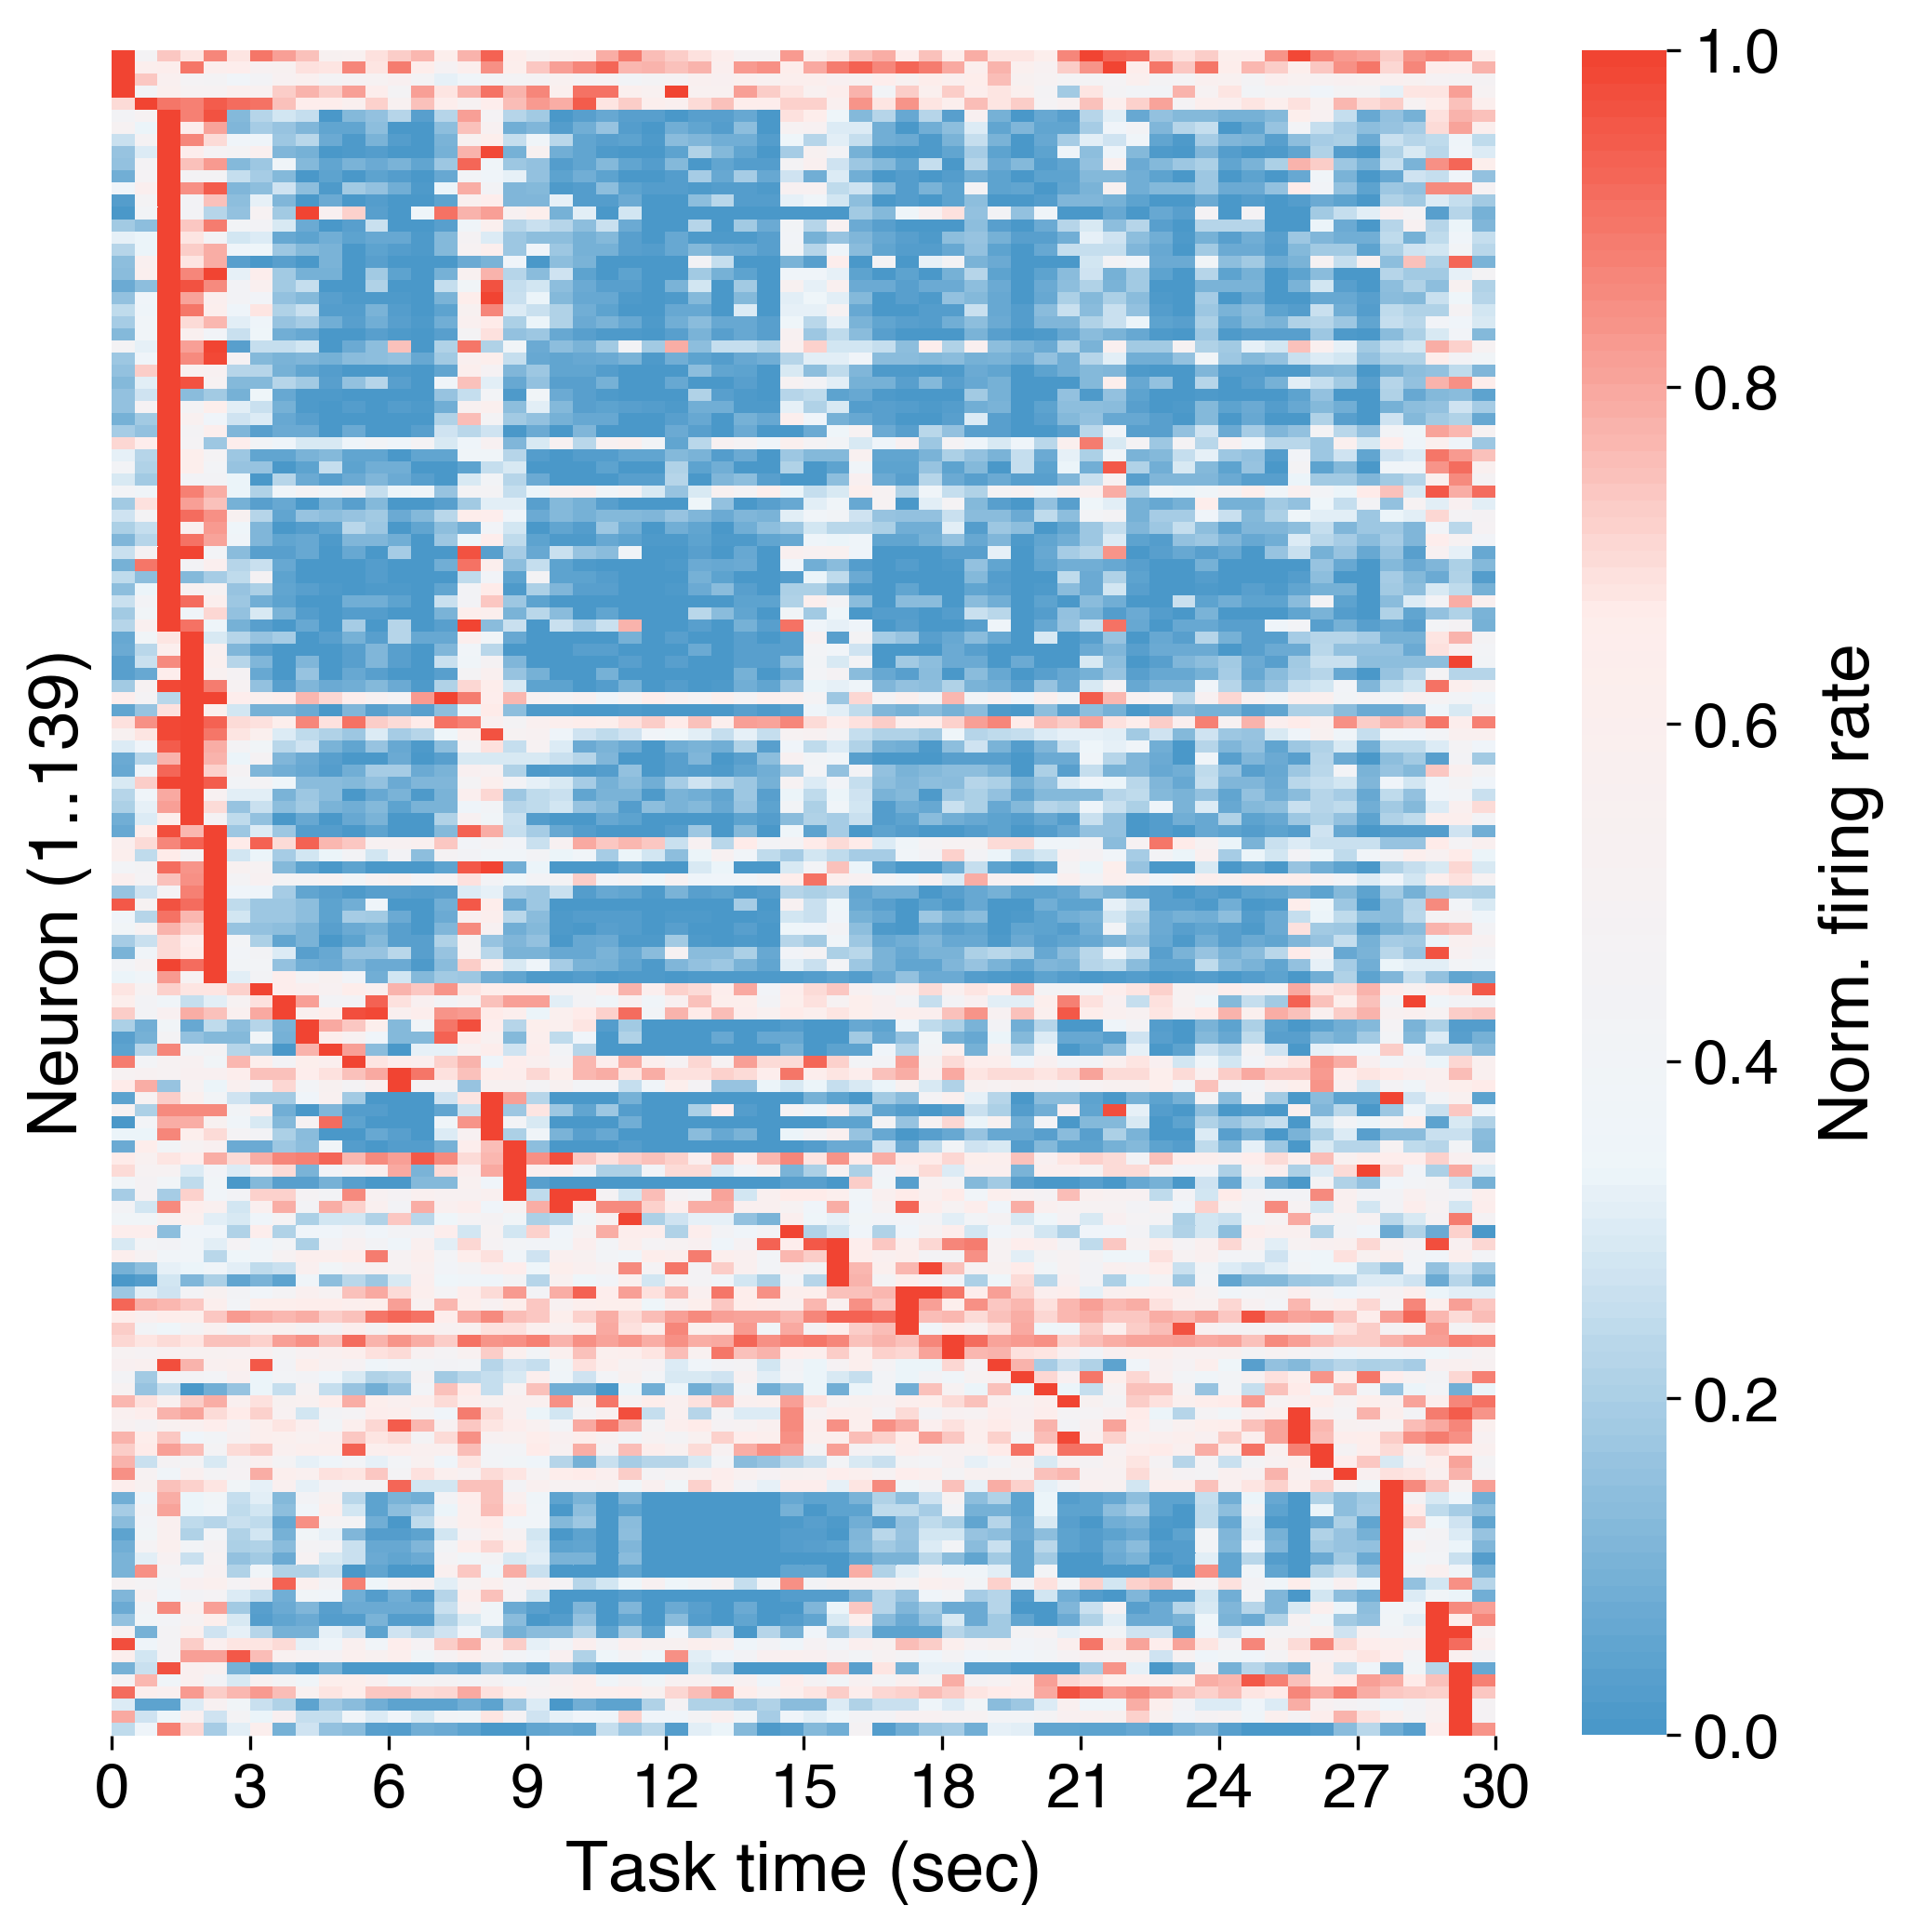

In [703]:
# For each neuron, add the number of spikes in 
# each time bin, across all task periods.
xtrial_task_spikes = np.sum(task_spikes, axis=-1) # neuron x time_bin

# Sort neurons in order of time bin with the highest firing rate
dat = xtrial_task_spikes[np.argsort(xtrial_task_spikes.argmax(axis=-1)), :]

# For each cell, divide the firing rate in each time bin
# by the firing rate in its maximum time bin
dat = dat / np.expand_dims(np.max(dat, axis=-1), axis=-1)

fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=300)
ax = np.ravel(ax)

tickfontsize = 16
labelfontsize = 18

i = 0
ax[i] = sns.heatmap(dat, cmap=cmap, cbar=True, square=False, ax=ax[i])
ax[i].set_xticks(np.linspace(0, 60, 11))
ax[i].set_xticklabels(np.linspace(0, 30, 11, dtype=int), fontsize=tickfontsize, rotation=0)
ax[i].set_yticks([])
ax[i].set_xlabel('Task time (sec)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('Neuron (1..{})'.format(xtrial_task_spikes.shape[0]), fontsize=labelfontsize, labelpad=5)
cbar = ax[i].collections[0].colorbar
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.ax.ticklabel_format()
cbar.set_label('Norm. firing rate', fontsize=labelfontsize)

## Analyze delay period activity

In [704]:
# Get the start and stop times for each delay period, for each trial.
df1 = game_state_intervals(events, game_state='Delay1', cols=['time'])
df2 = game_state_intervals(events, game_state='Delay2', cols=['time'])
df1.insert(1, 'gameState', 'Delay1')
df2.insert(1, 'gameState', 'Delay2')
delay_times = pd.concat((df1, df2), axis=0)

# Divide each delay period into 50 time bins of equal duration
# (should be ~500 ms each)
n_time_bins = 20
delay_times['time_bins'] = delay_times['time'].apply(lambda x: np.linspace(x[0], x[1], num=n_time_bins+1))
delay_time_bins = np.array(delay_times['time_bins'].tolist()) # event x time_bin

print(delay_time_bins.shape)

(24, 21)


In [705]:
# For each neuron, get the number of spikes in each delay period time bin
start_time = time()

delay_spikes = np.array([[[np.sum(np.logical_and(spike_dat.loc[iUnit, 'spike_times']>delay_time_bins[iEvent, iTime], 
                                                 spike_dat.loc[iUnit, 'spike_times']<=delay_time_bins[iEvent, iTime+1]))
                            for iEvent in range(delay_time_bins.shape[0])]
                          for iTime in range(delay_time_bins.shape[1]-1)]
                         for iUnit in range(len(spike_dat))])
print(delay_spikes.shape) # neuron x time_bin x event

print('Done in {:.2f} secs'.format(time() - start_time))

(139, 20, 24)
Done in 3.11 secs


In [793]:
bs_inds.shape, delay_spikes.shape

((1000, 20), (139, 20, 24))

In [616]:
# # Determine how many spikes a neuron must fire during the
# # delay period to be considered "active" (taking average
# # spikes across trials)
# active_rate = 1 # in Hz
# time_bin_length = 0.5 # in sec
# # ---------------------------------------------------

# min_spikes = active_rate * time_bin_length
# delay_active_units = np.where(np.mean(delay_spikes, axis=(1, 2))>min_spikes)[0]
# # delay_spikes_active = delay_spikes[delay_active_units, :, :] # neuron x time_bin x event
# delay_spikes_active = np.array([delay_spikes[iUnit, :, :] 
#                                 for iUnit in range(delay_spikes.shape[0])
#                                 if np.max(np.mean(delay_spikes[iUnit, :, :], axis=-1))>min_spikes])

# print('Print {}/{} active delay cells'.format(delay_spikes_active.shape[0], delay_spikes.shape[0]))

Print 177/247 active delay cells


In [833]:
# Use a Friedman test to assess unequal firing rates across time bins,
# for each neuron. 
friedman_pvals = []
for iUnit in range(delay_spikes.shape[0]):
    friedman_pvals.append(stats.friedmanchisquare(*delay_spikes[iUnit, :, :])[1])
friedman_pvals = np.array(friedman_pvals)

# FDR correct the p-values.
sig_fdr, pvals_fdr, *_ = sm.stats.multipletests(friedman_pvals, alpha=0.05, method='fdr_tsbky', is_sorted=False, returnsorted=False)

print(np.sum(friedman_pvals<0.05), np.sum(sig_fdr), len(friedman_pvals))

27 3 139


In [836]:
np.argsort(pvals_fdr)

array([ 36,   1,  50,   6,  22, 124,  40,  33, 107, 123,  11,  46, 130,
        35,  16,   2,  49,   3, 132,  48,  51,  44, 118, 114,  42, 116,
        53, 135,  45,   4,  20,   7,  23,  91,  14, 128,  43,   8, 106,
        82, 117, 126,   9,  47, 134, 137,  96, 131,  37,  34,  32,  13,
        15,  26, 129,  12,  66, 127,  52,  69,  41,  97, 122, 104, 109,
       115,  74, 119,  63,  68, 125,  25,  31,  21, 133,  17,  10,  55,
        24, 120,  79,   5,  67,  71, 100,  65,  86,  18,  38,  54,  76,
       103, 105, 136, 102,   0,  77,  70,  72,  73,  75,  95,  80,  81,
        83,  84,  60,  29,  19,  39,  27,  28,  30,  98, 101,  85,  56,
        78, 110, 113,  64, 108,  58,  57,  59,  94,  62, 121, 112, 111,
        87,  88,  89,  90,  92,  99,  93,  61, 138])

In [798]:
def get_n_sig(delay_spikes):
    friedman_pvals = [stats.friedmanchisquare(*delay_spikes[iUnit, :, :])[1]
                      for iUnit in range(delay_spikes.shape[0])]
    return np.sum(sm.stats.multipletests(friedman_pvals, 
                                         alpha=0.05, 
                                         method='fdr_tsbky', 
                                         is_sorted=False, 
                                         returnsorted=False)[0])

In [802]:
n_bootstraps = 1000
bs_inds = np.array([np.random.permutation(np.arange(delay_spikes.shape[1]))
                    for iBoot in range(n_bootstraps)]) # bs_ind x time_bin

In [794]:
# Build a null distribution by shifting time bins from each event
iBoot = 0
delay_spikes[:, bs_inds[iBoot, :], :].shape

(139, 20, 24)

In [817]:
bs_inds[2, :]

array([ 5,  6, 11, 16,  3,  8, 10,  9, 13, 17,  4,  7, 19, 15,  0, 12, 18,
       14,  1,  2])

In [824]:
np.sum(delay_spikes, axis=2)[0, :]

array([ 66,  57,  66,  46, 105,  49,  66,  81,  39,  53,  54,  53,  58,
        52,  46,  68,  45,  55,  48,  81])

In [826]:
np.moveaxis([delay_spikes[:, bs_inds[iEvent, :], iEvent] for iEvent in range(delay_spikes.shape[2])], 0, 2)

(139, 20, 24)

In [804]:
np.unique(bs_n_sig, return_counts=True)

(array([3]), array([1000]))

In [617]:
# spike_dat['active_delay'] = False
# spike_dat.loc[delay_active_units, 'active_delay'] = True

In [707]:
# spike_dat.groupby('hemroi').agg({'active_delay': [len, np.sum, np.mean], 'active_task': [len, np.sum, np.mean]})

In [547]:
# chan 2, 4, 20, 75, 75 // RAH (2), ROF (1), LMTG (2)

In [965]:
# What are the sig cells?
spike_dat.loc[[33, 34, 35, 36, 37, 38, 39, 40, 46, 47, 48, 49, 50, 107, 123]]

subj_sess  subj  sess  chan  unit  \
33   U515_ses0  U515  ses0    20     1   
34   U515_ses0  U515  ses0    20     2   
35   U515_ses0  U515  ses0    21     1   
36   U515_ses0  U515  ses0    21     2   
37   U515_ses0  U515  ses0    21     3   
38   U515_ses0  U515  ses0    21     4   
39   U515_ses0  U515  ses0    21     5   
40   U515_ses0  U515  ses0    21     6   
46   U515_ses0  U515  ses0    22     6   
47   U515_ses0  U515  ses0    23     1   
48   U515_ses0  U515  ses0    23     4   
49   U515_ses0  U515  ses0    24     1   
50   U515_ses0  U515  ses0    24     3   
107  U515_ses0  U515  ses0    64     1   
123  U515_ses0  U515  ses0    75     1   

                                           spike_times  n_spikes         fr  \
33   [7585.312500000001, 8172.71875, 8175.437500000...     10331   4.460829   
34   [21562.28125, 21592.312500000004, 22002.09375,...      4126   1.781568   
35   [7405.03125, 14393.46875, 18529.21875, 21593.8...      3417   1.475429   
36   [21734.625, 21736.125, 21996.28125, 21998.4062...      2087   0.901147   
37   [7478.343750000001, 7484.312500000001, 7486.25...      1901   0.820834   
38   [7482.437500000001, 21590.656250000004, 22002....      1702   0.734908   
39   [7488.15625, 8180.781250000001, 21739.9375, 22...      1637   0.706841   
40   [21592.312500000004, 22004.125000000004, 22006...      2052   0.886034   
46   [7478.40625, 7483.96875, 8173.187500000001, 81...      3239   1.398570   
47   [2029.40625, 4218.53125, 6285.3125, 7481.68750...     14303   6.175902   
48   [25028.625, 25069.53125, 25102.34375, 25315.75...      2428   1.048388   
49   [148.0, 280.34375, 556.96875, 609.84375, 784.1...      7815   3.374444   
50   [32128.406249999996, 32687.656250000004, 32689...      1798   0.776360   
107  [870.84375, 1026.3437500000002, 1165.531250000...      8710   3.760897   
123  [326.28125, 426.34375, 520.6562500000001, 580....     54124  23.370238   

    hemroi  
33     ROF  
34     ROF  
35     ROF  
36     ROF  
37     ROF  
38     ROF  
39     ROF  
40     ROF  
46     ROF  
47     ROF  
48     ROF  
49     ROF  
50     ROF  
107   LFSG  
123   LMTG

In [918]:
spike_dat.groupby('hemroi').indices

{'LA': array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
        87]),
 'LFSG': array([103, 104, 105, 106, 107, 108]),
 'LMTG': array([121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
        134, 135, 136, 137, 138]),
 'LOF': array([ 88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
        101, 102]),
 'LPHG': array([68, 69]),
 'LSTG': array([109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120]),
 'RA': array([18, 19, 20]),
 'RAH': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 'RFSG': array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]),
 'ROF': array([21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
        38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54])}

In [968]:
((0.05 - friedman_pvals)/0.05)

array([-12.61684956,   0.99545339,   0.59795936,   0.58444757,
        -0.34823083,  -9.02711046,   0.93721284,  -0.41357972,
        -1.89652635,  -1.47148589,  -7.50906427,   0.79802167,
        -3.20296604,  -2.79182612,  -0.90151297,  -2.33578924,
         0.64028714,  -7.50885163, -10.59747606, -13.64275763,
        -0.31635209,  -7.16378942,   0.93316257,  -0.61638267,
        -8.48108503,  -6.73067682,  -2.70149464, -12.41294204,
       -13.61891963, -12.89350412, -13.14655534,  -7.00313487,
        -2.78109318,   0.88736677,  -2.654029  ,   0.69760789,
         0.98968168,  -2.53155145, -10.61423031, -11.92405481,
         0.87505554,  -4.28733394,   0.040665  ,  -1.72825432,
         0.2680736 ,  -0.38841426,   0.65484117,  -1.4547215 ,
         0.33550712,   0.63686564,   0.98932134,   0.24598124,
        -4.0454689 ,   0.05764365, -10.93150047,  -8.15398353,
       -15.38375924, -17.32605848, -18.30116518, -18.57992137,
       -11.39734188, -18.62919461, -16.85540646,  -5.76

In [ ]:
[123, 36, 50, 1, 6, 11]

In [949]:
stats.spearmanr(delay_spikes[40, :, :].flatten(), delay_spikes[33, :, :].flatten())

SpearmanrResult(correlation=0.5926812926893532, pvalue=7.423963795694827e-47)

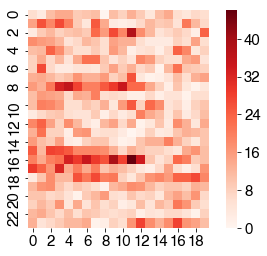

In [988]:
sns.heatmap(delay_spikes[123, :, :].T, cmap='Reds', square=True) #107

In [1015]:
spike_dat.iloc[1]['hemroi']

'RAH'

In [1036]:
np.ravel([(i, '') for i in range(1, 12, 2)])

array(['1', '', '3', '', '5', '', '7', '', '9', '', '11', ''],
      dtype='<U21')

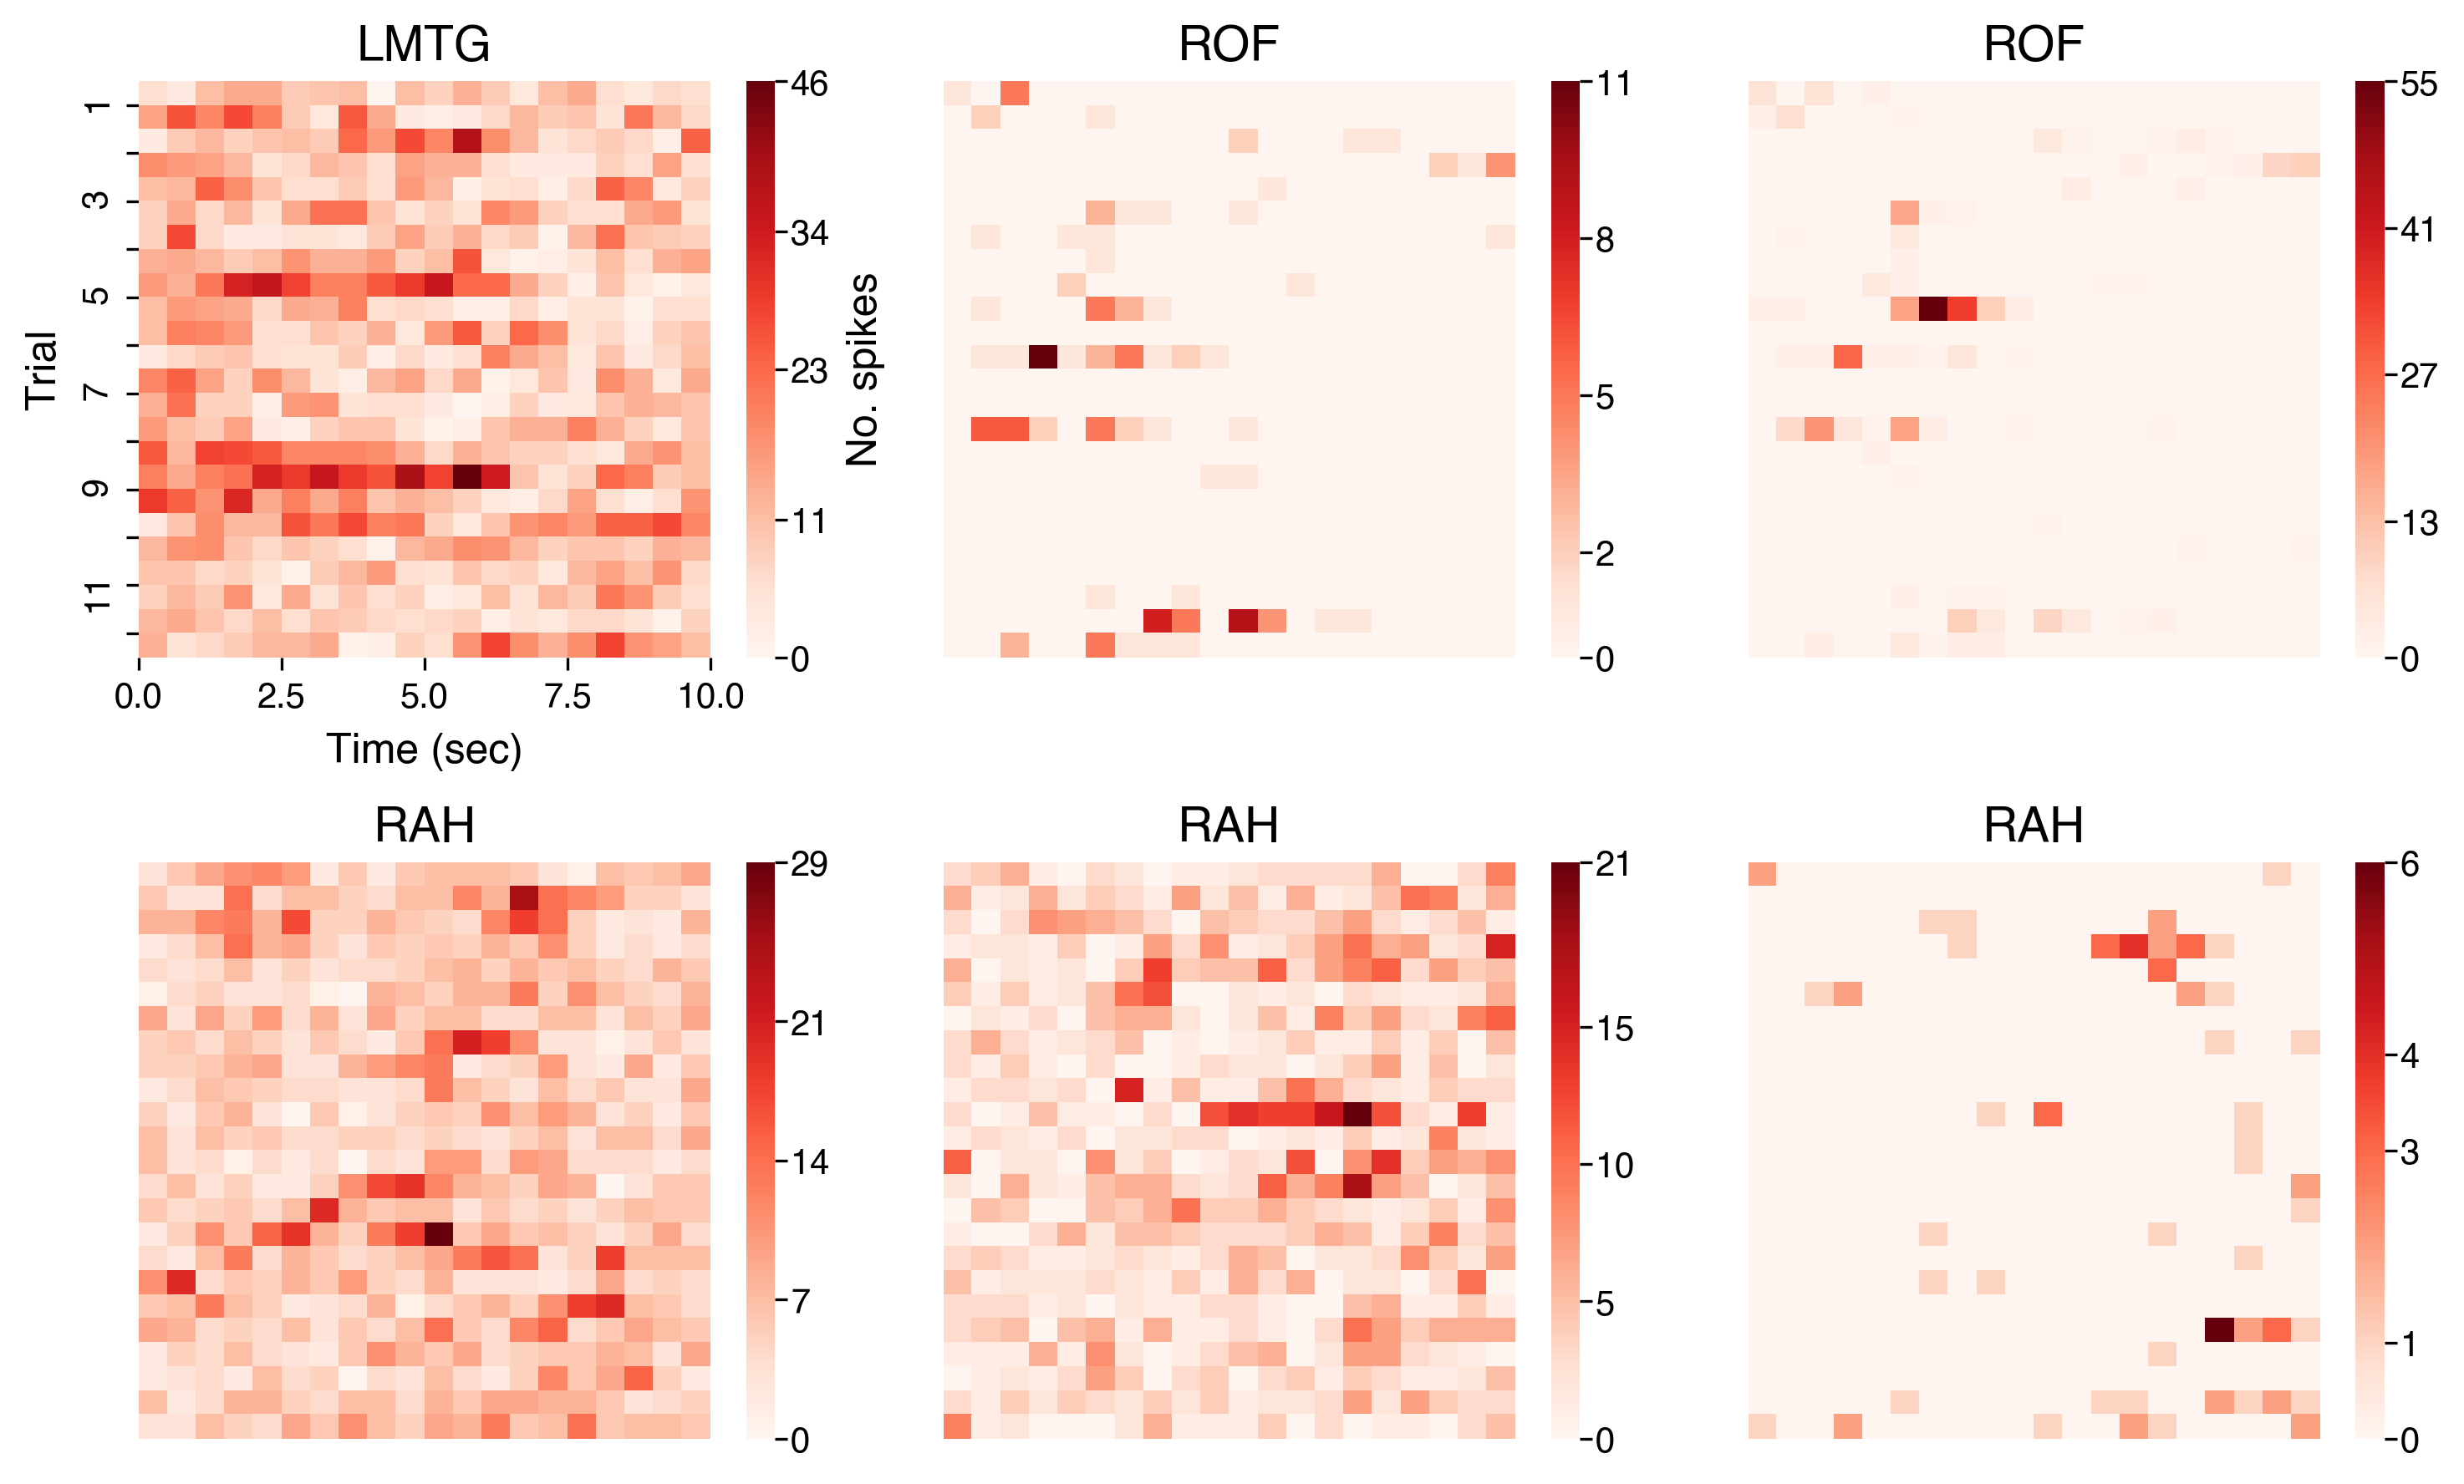

In [1042]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6), dpi=300)
ax = np.ravel(ax)

tickfontsize = 10
labelfontsize = 12
figfontsize = 14

show_units = [123, 36, 22, 1, 6, 11]
for i in range(6):
    ax[i] = sns.heatmap(delay_spikes[show_units[i], :, :].T, cmap='Reds', square=False, ax=ax[i])
    ax[i].set_title(spike_dat.iloc[show_units[i]]['hemroi'], fontsize=figfontsize, y=1.05)
    cbar = ax[i].collections[0].colorbar
    cbar.ax.tick_params(labelsize=tickfontsize, pad=1)
    vmin = np.min(delay_spikes[show_units[i], :, :])
    vmax = np.max(delay_spikes[show_units[i], :, :])
    cbar.set_ticks(np.linspace(int(vmin), int(vmax), 5, dtype=int))
    cbar.set_ticklabels(np.linspace(int(vmin), int(vmax), 5, dtype=int))
    
    if i > 0:
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
    if i == 0:
        ax[i].set_xticks(np.linspace(0, 20, 5))
        ax[i].set_yticks(np.arange(0, 23, 2)+1)
        ax[i].set_xticklabels(np.linspace(0, 10, 5), fontsize=tickfontsize)
        ax[i].set_yticklabels(np.ravel([(i, '') for i in range(1, 12, 2)]), fontsize=tickfontsize)
        ax[i].set_xlabel('Time (sec)', fontsize=labelfontsize, labelpad=5)
        ax[i].set_ylabel('Trial', fontsize=labelfontsize, labelpad=5)
        cbar.set_label('No. spikes', fontsize=labelfontsize, labelpad=5)

fig.tight_layout(pad=1)

In [796]:
np.array_equal(delay_spikes[:, bs_inds[iBoot, :], :], delay_spikes)
np.array_equal(np.sum(delay_spikes[:, bs_inds[iBoot, :], :], axis=-1), np.sum(delay_spikes, axis=-1))

False

In [1085]:
delay_spikes.shape

(139, 20, 24)

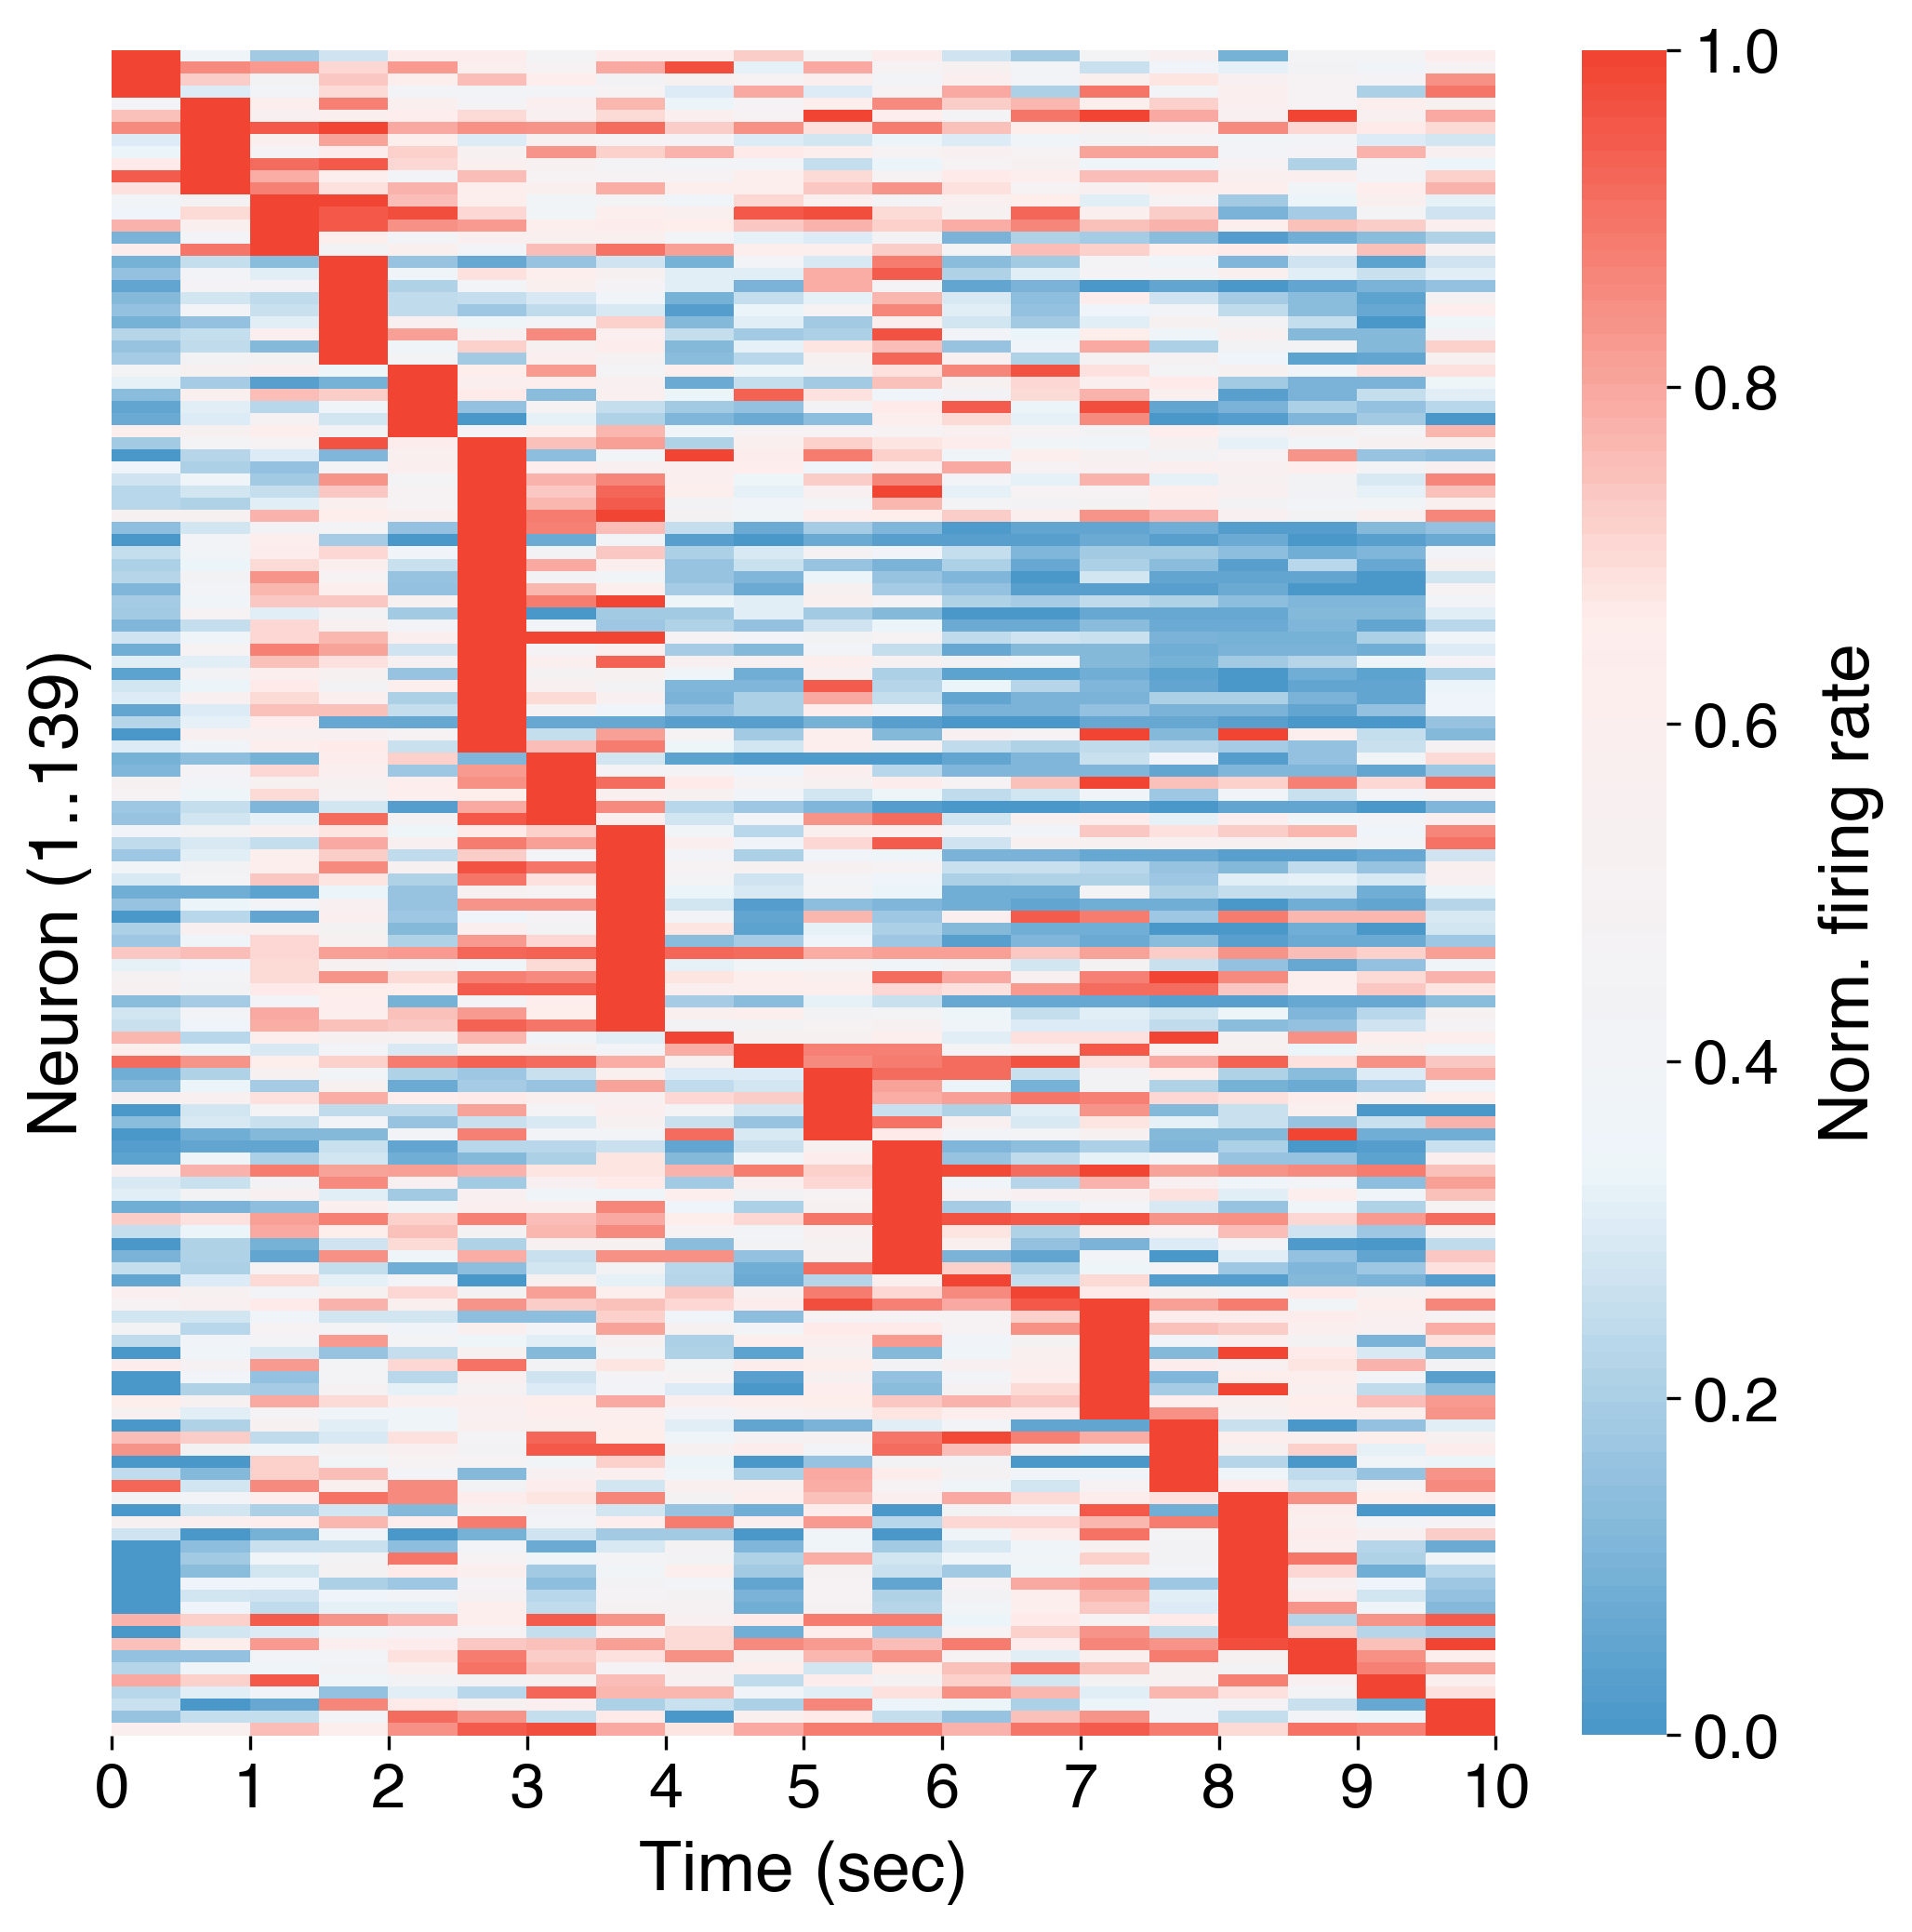

In [1086]:
# For each neuron, add the number of spikes in 
# each time bin, across all delay periods.
bs_inds = np.array([np.random.permutation(np.arange(delay_spikes.shape[1]))
                    for iBoot in range(delay_spikes.shape[2])]) # bs_ind x time_bin
# np.moveaxis([delay_spikes[:, bs_inds[iEvent, :], iEvent] for iEvent in range(delay_spikes.shape[2])], 0, 2)
xtrial_delay_spikes = np.mean(delay_spikes, axis=-1) # neuron x time_bin

# Sort neurons in order of time bin with the highest firing rate
dat = xtrial_delay_spikes[np.argsort(xtrial_delay_spikes.argmax(axis=-1)), :]

# For each cell, divide the firing rate in each time bin
# by the firing rate in its maximum time bin
dat = dat / np.expand_dims(np.max(dat, axis=-1), axis=-1)

fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=300)
ax = np.ravel(ax)

tickfontsize = 16
labelfontsize = 18

i = 0
ax[i] = sns.heatmap(dat, cmap=cmap, cbar=True, square=False, ax=ax[i])
ax[i].set_xticks(np.linspace(0, 20, 11))
ax[i].set_xticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=tickfontsize, rotation=0)
ax[i].set_yticks([])
ax[i].set_xlabel('Time (sec)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('Neuron (1..{})'.format(xtrial_delay_spikes.shape[0]), fontsize=labelfontsize, labelpad=5)
cbar = ax[i].collections[0].colorbar
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.ax.ticklabel_format()
cbar.set_label('Norm. firing rate', fontsize=labelfontsize)

## Analyze trial phases

In [710]:
trial_phases = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
trial_times = np.array([game_state_intervals(events, game_state=trial_phase, cols=['time']).time.tolist()
                        for trial_phase in trial_phases]) # trial_phase x event x (time_start, time_stop)
trial_times.shape

(4, 12, 2)

In [711]:
# For each neuron, get the number of spikes/sec in each task period time bin
start_time = time()

delay_secs = 10.0
task_secs = 30.0
trial_spikes = np.array([[[np.sum(np.logical_and(spike_dat.loc[iUnit, 'spike_times']>trial_times[iTrialPhase, iEvent, 0], 
                                                 spike_dat.loc[iUnit, 'spike_times']<=trial_times[iTrialPhase, iEvent, 1]))
                            for iEvent in range(trial_times.shape[1])]
                          for iTrialPhase in range(trial_times.shape[0])]
                         for iUnit in range(len(spike_dat))])
trial_spikes[:, [0, 2], :] = trial_spikes[:, [0, 2], :] / delay_secs
trial_spikes[:, [1, 3], :] = trial_spikes[:, [1, 3], :] / task_secs
print(trial_spikes.shape, trial_spikes.sum()) # neuron x trial_phase x event

print('Done in {:.2f} secs'.format(time() - start_time))

(139, 4, 12) 15335
Done in 0.36 secs


In [714]:
xtrial_spikes = np.mean(trial_spikes, axis=-1) # neuron x trial_phase

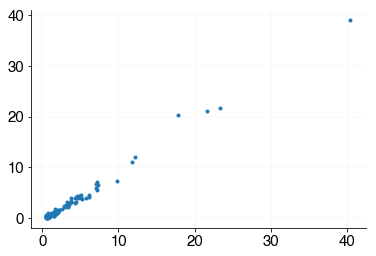

In [717]:
plt.scatter(np.array(spike_dat['fr'].tolist())[:130], np.mean(xtrial_spikes, axis=-1)[:130])

In [1083]:
spike_dat['fr_diffs'] = fr_diffs
spike_dat.groupby('hemroi').agg({'fr_diffs': np.mean})

fr_diffs
hemroi          
LA      0.388889
LFSG   -0.208333
LMTG    0.208333
LOF     0.616667
LPHG    0.125000
LSTG   -0.562500
RA      0.166667
RAH     1.152778
RFSG    0.192308
ROF     0.235294

Text(0, 0.5, 'No. of cells')

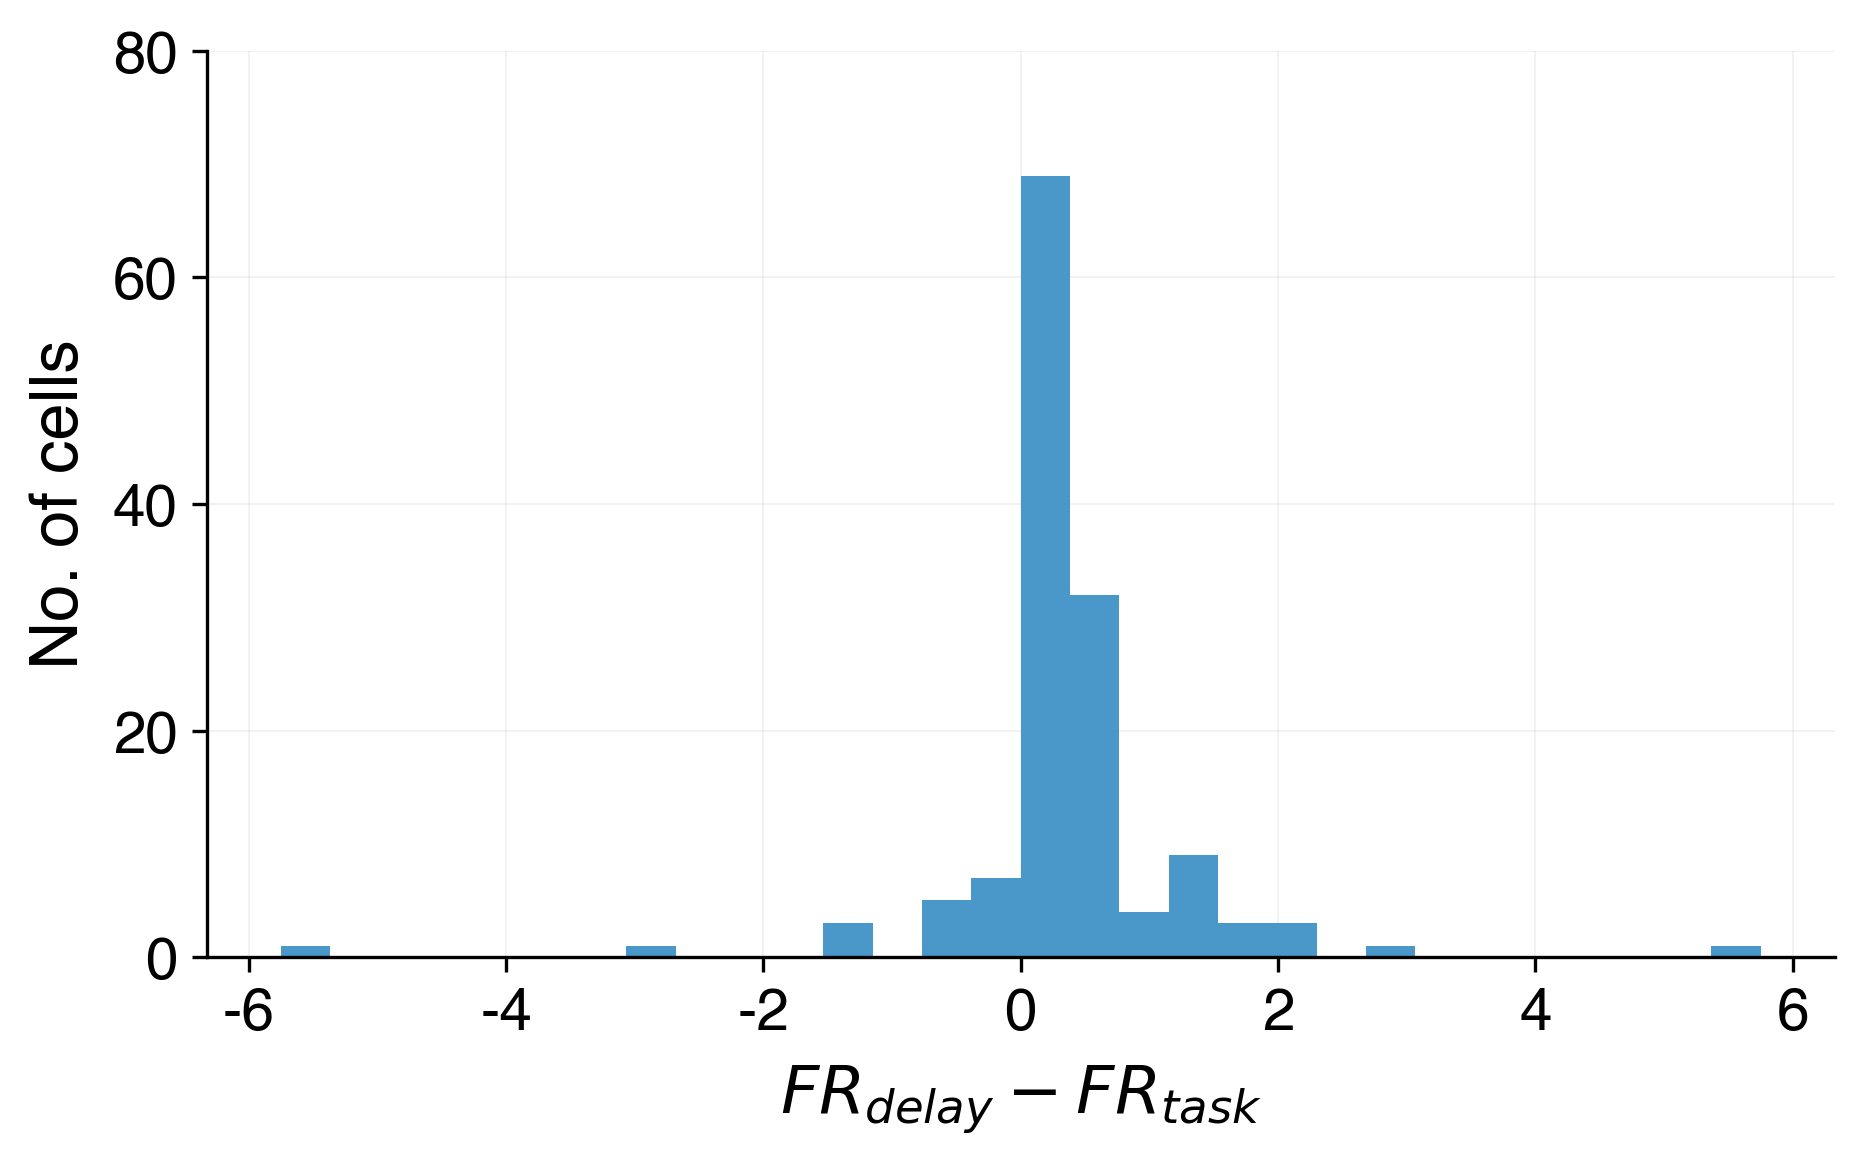

In [1078]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4), dpi=300)
ax = np.ravel(ax)

tickfontsize = 14
labelfontsize = 16

fr_pairs = np.array([np.mean(trial_spikes[:, [0, 2], :], 1), # delay periods
                     np.mean(trial_spikes[:, [1, 3], :], 1)]) # task periods
fr_pairs = np.moveaxis(fr_pairs, 0, -1)
fr_diffs = np.array([np.median(fr_pairs[iUnit, :, 0]) - np.median(fr_pairs[iUnit, :, 1])
                     for iUnit in range(fr_pairs.shape[0])])

i = 0
ax[i].hist(fr_diffs, bins=30, color=colors[0])
ax[i].set_xticks(np.linspace(-6, 6, 7, dtype=int))
ax[i].set_xticklabels(np.linspace(-6, 6, 7, dtype=int), fontsize=tickfontsize)
ax[i].set_yticks(np.linspace(0, 80, 5, dtype=int))
ax[i].set_yticklabels(np.linspace(0, 80, 5, dtype=int), fontsize=tickfontsize)
ax[i].set_xlabel('$FR_{delay} - FR_{task}$', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('No. of cells', fontsize=labelfontsize, labelpad=5)

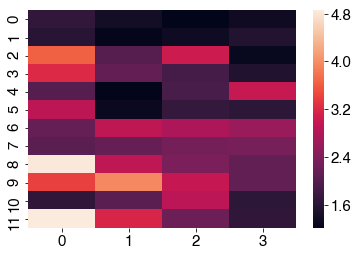

In [741]:
sns.heatmap(np.mean(trial_spikes, axis=0).T)

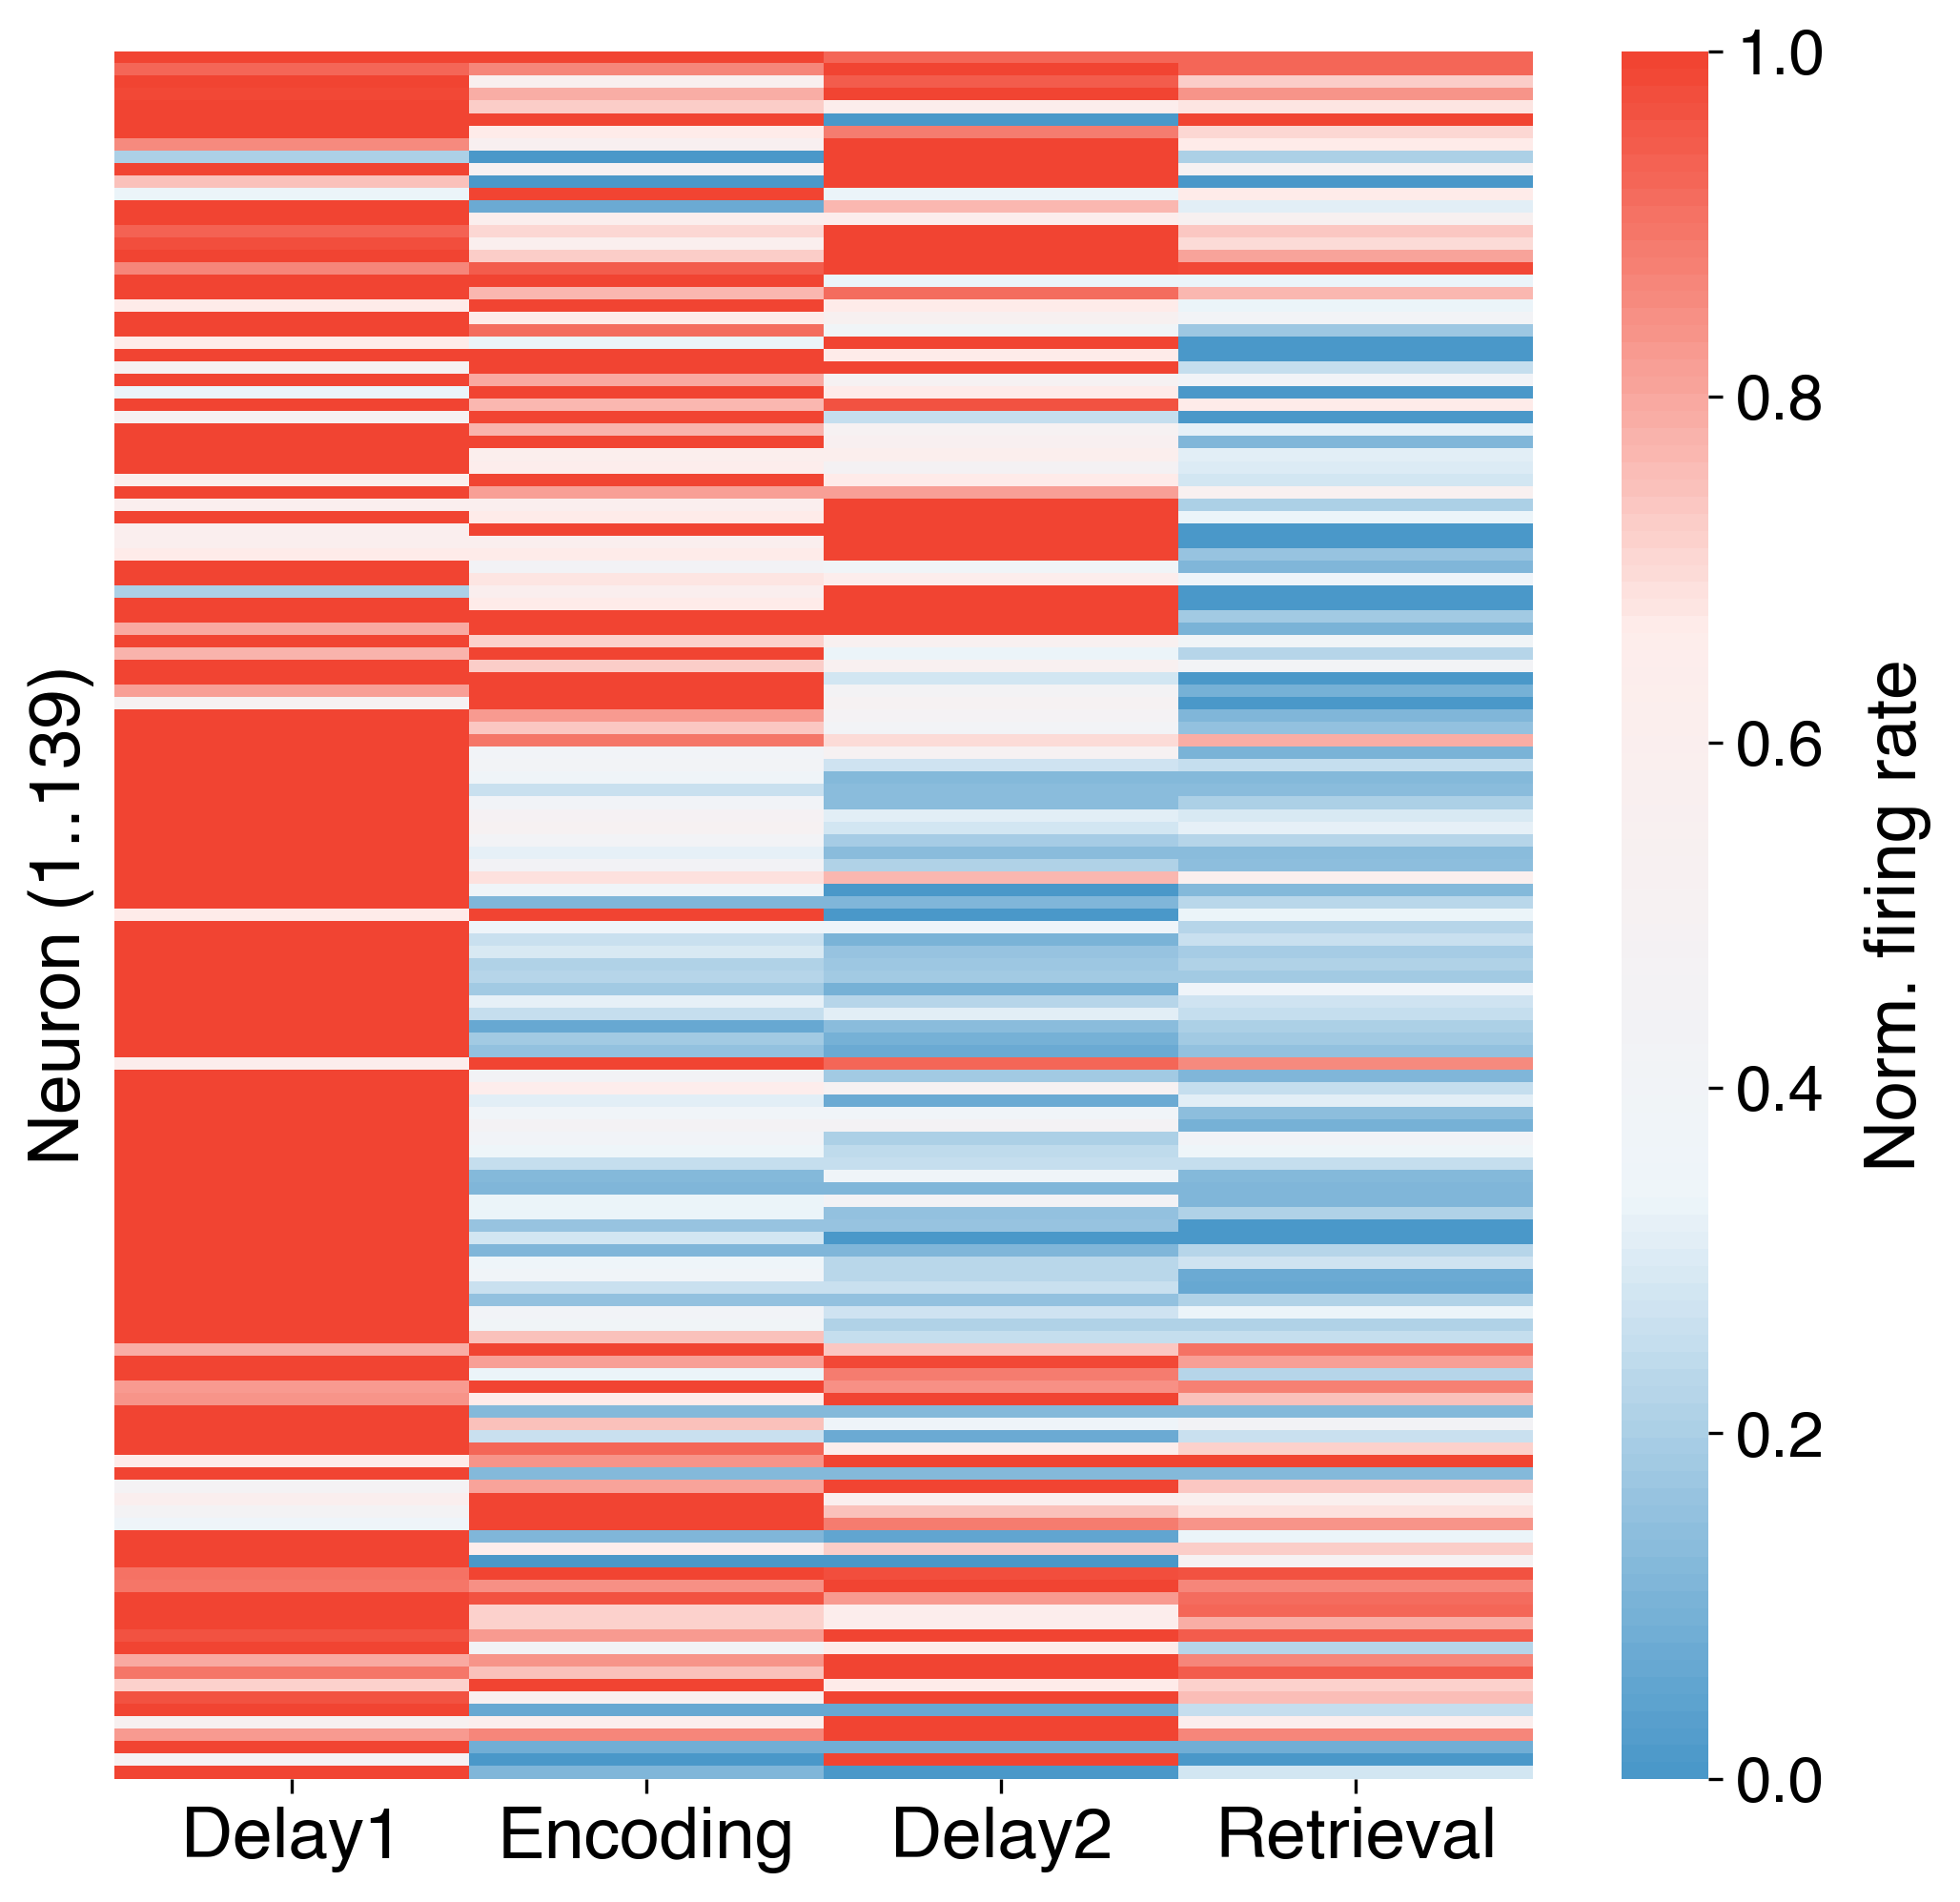

In [726]:
# For each neuron, calculate the mean firing rate during each trial phase.
xtrial_fr = np.mean(trial_spikes, axis=-1) # neuron x trial_phase

# Sort neurons in order of time bin with the highest firing rate
dat = xtrial_fr#[np.argsort(xtrial_fr.argmax(axis=-1)), :]

# For each cell, divide the firing rate in each time bin
# by the firing rate in its maximum time bin
dat = dat / np.expand_dims(np.max(dat, axis=-1), axis=-1)

fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=300)
ax = np.ravel(ax)

tickfontsize = 16
labelfontsize = 18

i = 0
ax[i] = sns.heatmap(dat, cmap=cmap, cbar=True, square=False, ax=ax[i])
ax[i].set_xticks(np.arange(len(trial_phases))+0.5)
ax[i].set_xticklabels(trial_phases, fontsize=labelfontsize, rotation=0)
ax[i].set_yticks([])
ax[i].set_ylabel('Neuron (1..{})'.format(xtrial_fr.shape[0]), fontsize=labelfontsize, labelpad=5)
cbar = ax[i].collections[0].colorbar
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.ax.ticklabel_format()
cbar.set_label('Norm. firing rate', fontsize=labelfontsize)

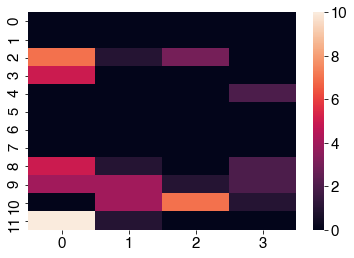

In [737]:
sns.heatmap(trial_spikes[70, :, :].T)

## Alignment plots

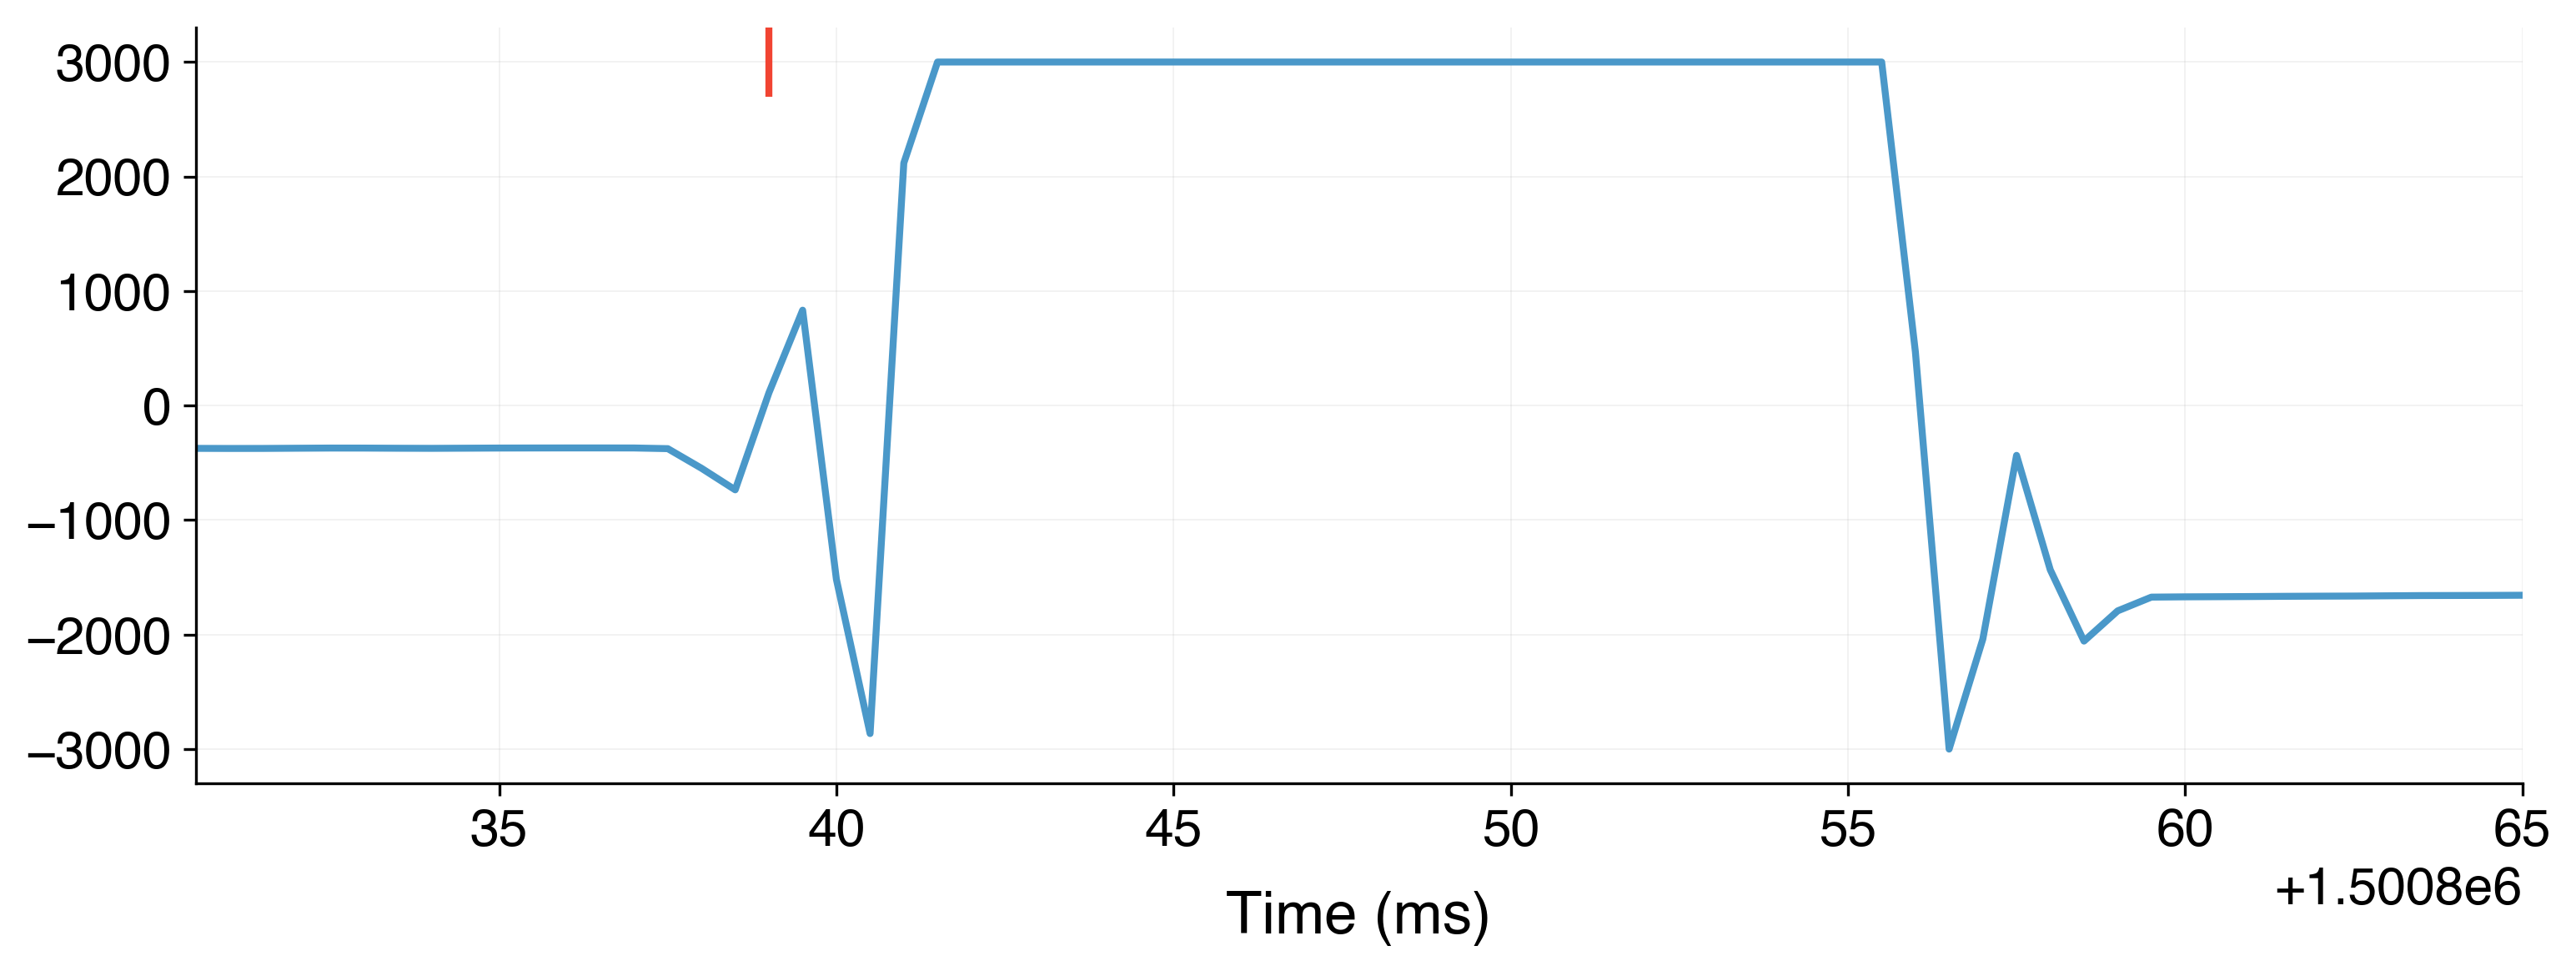

In [56]:
pulse_startinds = find_pulse_starts(sync_chan)
pulse_starts = np.zeros(len(sync_chan))
pulse_starts[pulse_startinds] = 3000

fig, ax = plot_trace(np.vstack((sync_chan, pulse_starts)),
                     start=1500.83*1e3, stop=1500.865*1e3, x_units='ms', sampling_rate=2000,
                     colors=[colors[0], colors[1]], linewidths=[2, 0], 
                     markers=[None, '|'], markeredgewidths=[0, 2])
fig.show()

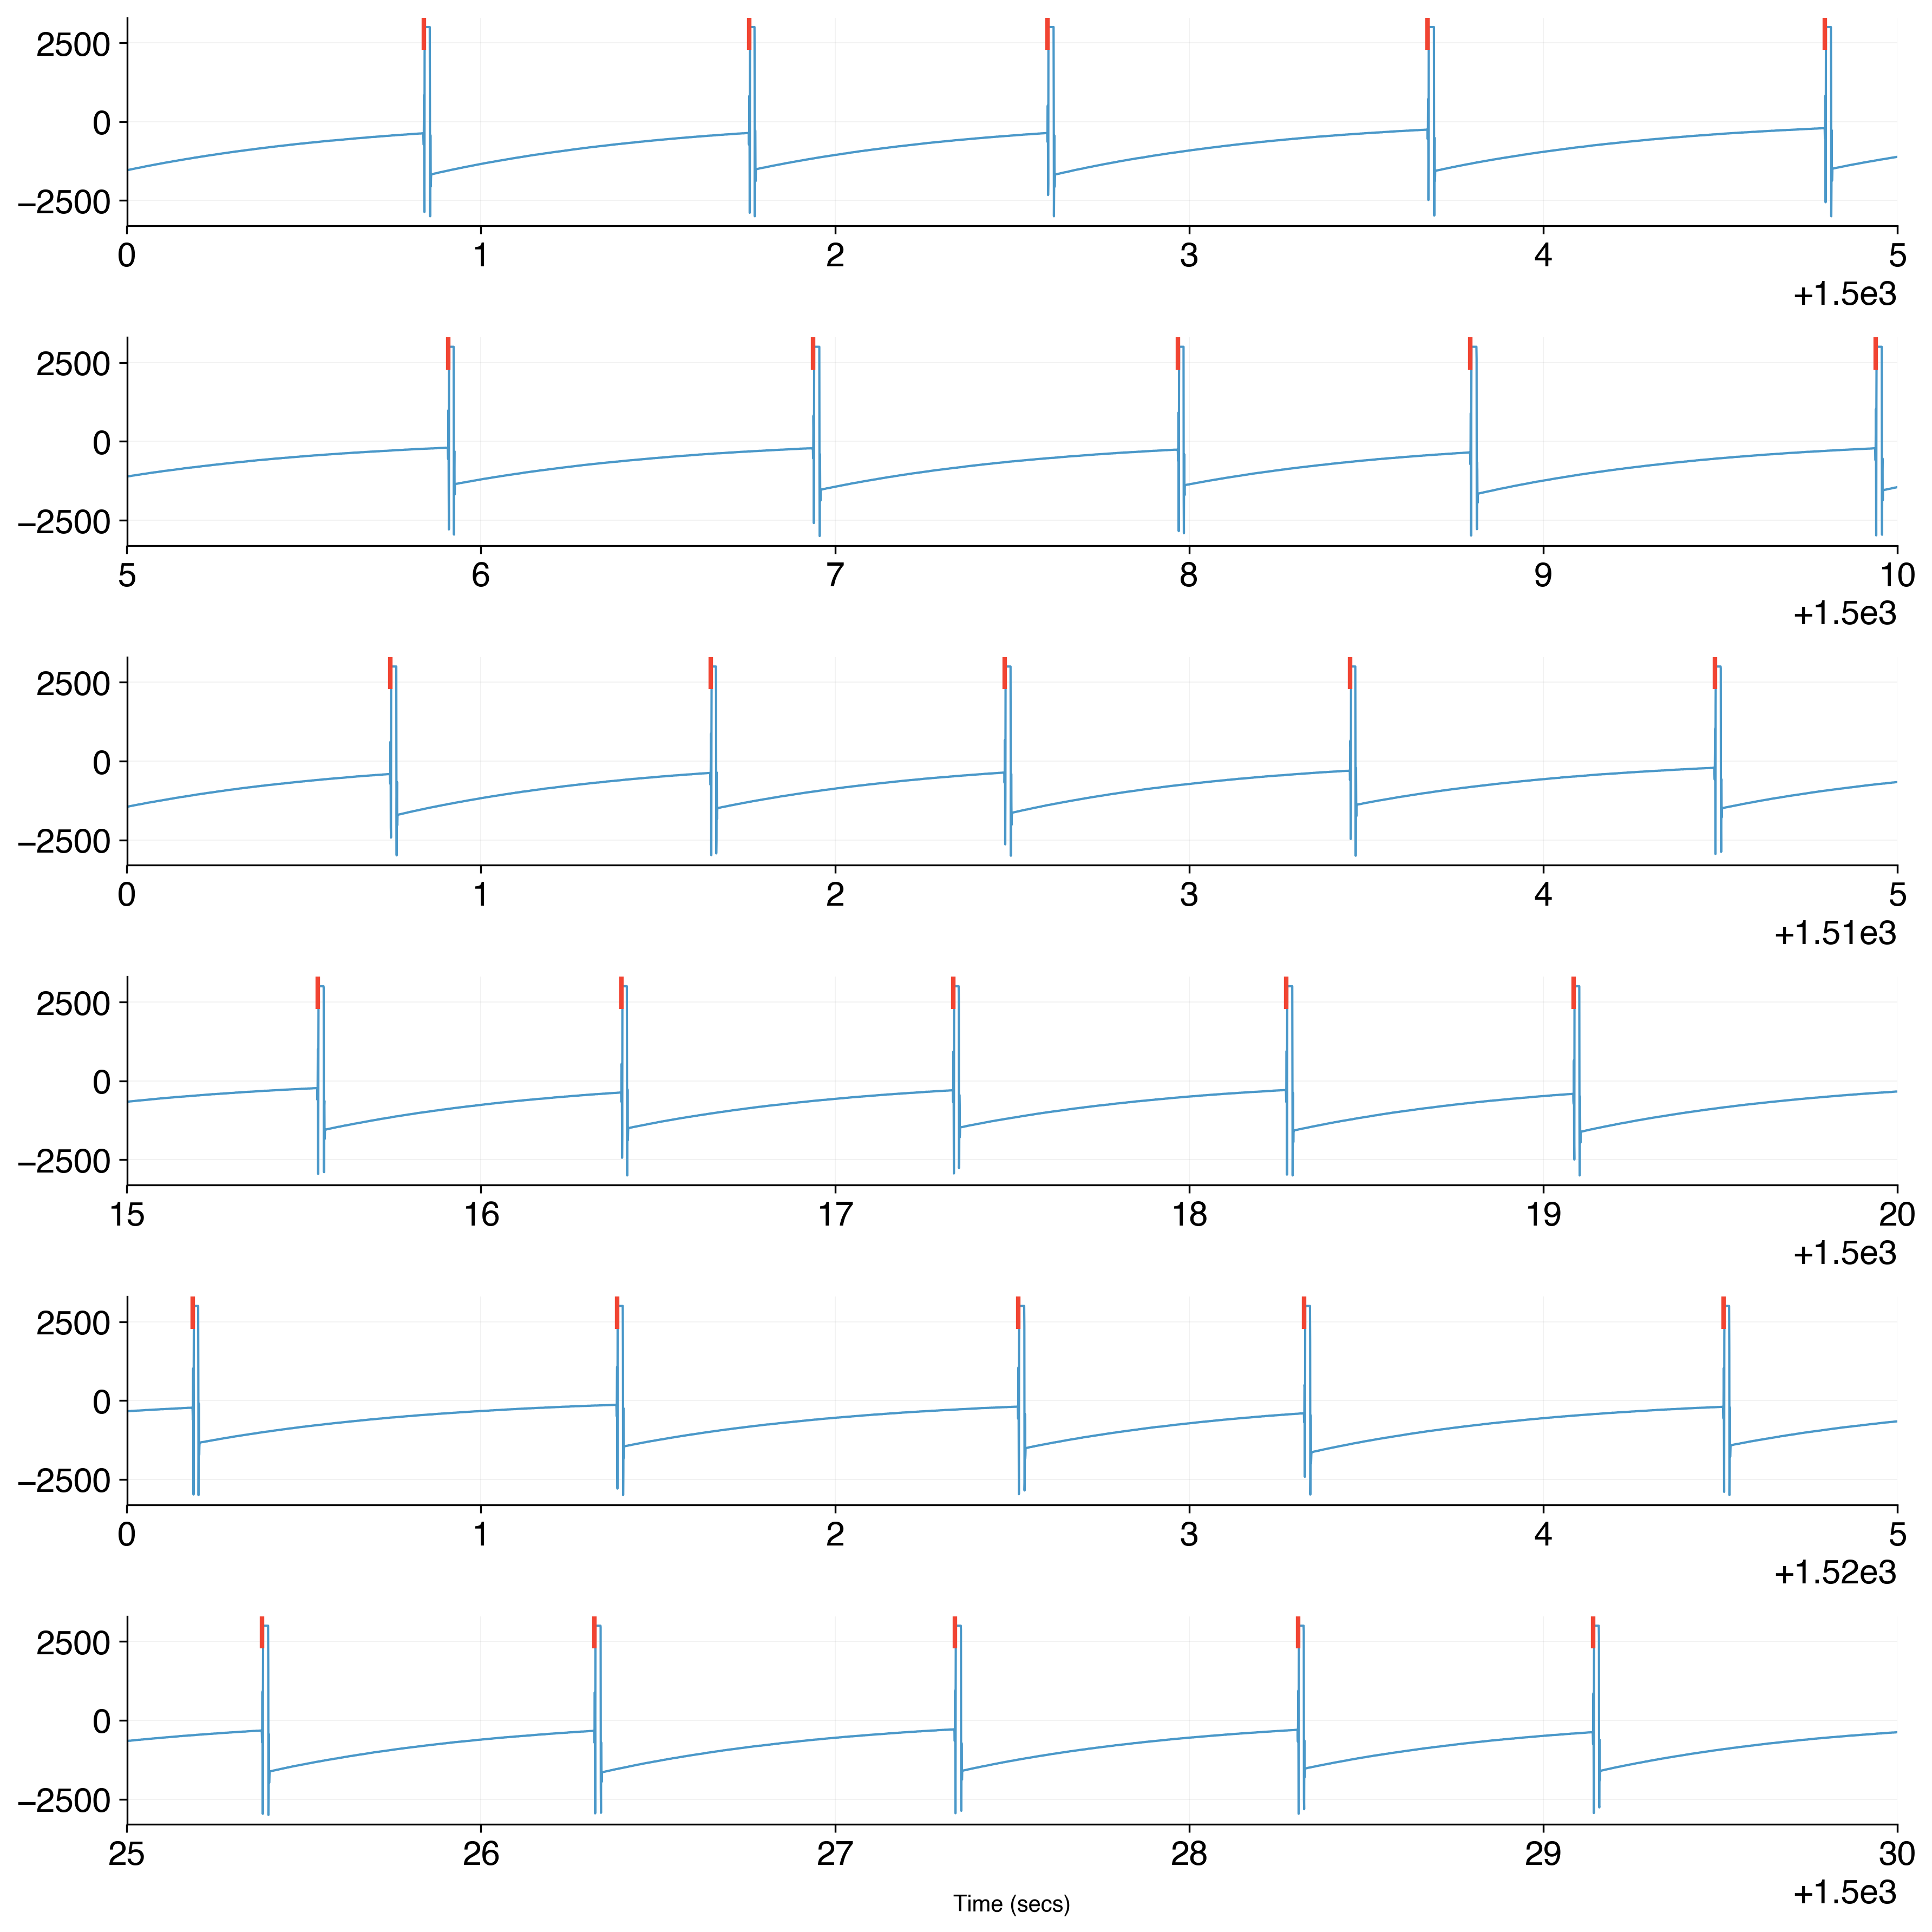

In [116]:
pulse_startinds = find_pulse_starts(sync_chan)
pulse_starts = np.zeros(len(sync_chan))
pulse_starts[pulse_startinds] = 3000

fig, ax = plot_trace2(np.vstack((sync_chan, pulse_starts)), figsize=(12, 12),
                      start=1500, stop=1530, x_units='secs', sampling_rate=2000,
                      colors=[colors[0], colors[1]], linewidths=[1, 0], 
                      markers=[None, '|'], markeredgewidths=[0, 2])
fig.show()